<a href="https://colab.research.google.com/github/arz03/CME_Analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
import cdflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timezone
import os
import glob
from pathlib import Path
import gc

# BLK Setup

In [23]:
# Variable configuration dictionary with metadata
VARIABLE_CONFIG = {
    'proton_density': {
        'df_name': 'Proton_Density',
        'units': '#/cm³',
        'label': 'Proton Number Density',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 150.0,
        'uncertainty_var': 'numden_p_uncer',
        'sig_digits': 2
    },
    'proton_bulk_speed': {
        'df_name': 'Proton_Bulk_Speed',
        'units': 'km/s',
        'label': 'Proton Bulk Speed',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 1200.0,
        'uncertainty_var': 'bulk_p_uncer',
        'sig_digits': 2
    },
    'alpha_density': {
        'df_name': 'Alpha_Density',
        'units': '#/cm³',
        'label': 'Alpha Number Density',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 150.0,
        'uncertainty_var': 'numden_a_uncer',
        'sig_digits': 2
    },
    'proton_xvelocity': {
        'df_name': 'Proton_X_Velocity',
        'units': 'km/s',
        'label': 'Proton Velocity (X-GSE)',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 1200.0,
        'uncertainty_var': 'bulk_p_uncer',
        'sig_digits': 2
    },
    'proton_yvelocity': {
        'df_name': 'Proton_Y_Velocity',
        'units': 'km/s',
        'label': 'Proton Velocity (Y-GSE)',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 1200.0,
        'uncertainty_var': 'bulk_p_uncer',
        'sig_digits': 2
    },
    'proton_zvelocity': {
        'df_name': 'Proton_Z_Velocity',
        'units': 'km/s',
        'label': 'Proton Velocity (Z-GSE)',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 1200.0,
        'uncertainty_var': 'bulk_p_uncer',
        'sig_digits': 2
    },
    'proton_thermal': {
        'df_name': 'Proton_Thermal',
        'units': 'km/s',
        'label': 'Proton Thermal Speed',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 200.0,
        'uncertainty_var': 'thermal_p_uncer',
        'sig_digits': 2
    },
    'alpha_bulk_speed': {
        'df_name': 'Alpha_Bulk_Speed',
        'units': 'km/s',
        'label': 'Alpha Bulk Speed',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 1200.0,
        'uncertainty_var': 'bulk_a_uncer',
        'sig_digits': 2
    },
    'alpha_thermal': {
        'df_name': 'Alpha_Thermal',
        'units': 'km/s',
        'label': 'Alpha Thermal Speed',
        'fillval': -1e31,
        'validmin': 0.0,
        'validmax': 200.0,
        'uncertainty_var': 'thermal_a_uncer',
        'sig_digits': 2
    },
    'spacecraft_xpos': {
        'df_name': 'Spacecraft_X_Pos',
        'units': 'km',
        'label': 'Spacecraft Position (X-GSE)',
        'fillval': -1e31,
        'validmin': -100000000.0,
        'validmax': 100000000.0,
        'uncertainty_var': None,
        'sig_digits': 2
    },
    'spacecraft_ypos': {
        'df_name': 'Spacecraft_Y_Pos',
        'units': 'km',
        'label': 'Spacecraft Position (Y-GSE)',
        'fillval': -1e31,
        'validmin': -100000000.0,
        'validmax': 100000000.0,
        'uncertainty_var': None,
        'sig_digits': 2
    },
    'spacecraft_zpos': {
        'df_name': 'Spacecraft_Z_Pos',
        'units': 'km',
        'label': 'Spacecraft Position (Z-GSE)',
        'fillval': -1e31,
        'validmin': -100000000.0,
        'validmax': 100000000.0,
        'uncertainty_var': None,
        'sig_digits': 2
    }
}

# Function to read and process a single BLK CDF file with metadata-driven cleaning
def process_single_blk_file(file_path):
    """
    Process a single BLK CDF file and return cleaned DataFrame with metadata-driven validation
    """
    blk_cdf = None
    try:
        print(f"Processing: {os.path.basename(file_path)}")

        # Open CDF file
        blk_cdf = cdflib.CDF(file_path)

        # Extract time variable
        epoch = blk_cdf['epoch_for_cdf_mod'][:]
        time = cdflib.cdfepoch.to_datetime(epoch)

        # Initialize data dictionary with time
        data = {"UTC": time}
        uncertainties = {}

        # Process each variable using metadata
        for cdf_var, config in VARIABLE_CONFIG.items():
            try:
                # Read the variable data
                var_data = blk_cdf[cdf_var][:]

                # Apply metadata-driven cleaning
                fillval = config['fillval']
                validmin = config['validmin']
                validmax = config['validmax']

                # Clean using metadata values
                cleaned_data = np.where(var_data == fillval, np.nan, var_data)
                cleaned_data = np.where(cleaned_data < validmin, np.nan, cleaned_data)
                cleaned_data = np.where(cleaned_data > validmax, np.nan, cleaned_data)

                data[config['df_name']] = cleaned_data

                # Try to read uncertainty data if available
                unc_var = config['uncertainty_var']
                if unc_var:
                    try:
                        unc_data = blk_cdf[unc_var][:]
                        unc_cleaned = np.where(unc_data == fillval, np.nan, unc_data)
                        uncertainties[config['df_name'] + '_Uncertainty'] = unc_cleaned
                    except:
                        pass  # Uncertainty variable not available

            except Exception as e:
                print(f"    Warning: Could not read {cdf_var}: {e}")
                # Fill with NaN if variable doesn't exist
                data[config['df_name']] = np.full(len(time), np.nan)

        # Add uncertainties to data
        data.update(uncertainties)

        # Create DataFrame
        df = pd.DataFrame(data)

        # Apply mask for primary variables (must have valid data)
        primary_vars = ["Proton_Density", "Proton_Bulk_Speed", "Alpha_Density"]
        mask = pd.Series(True, index=df.index)

        for var in primary_vars:
            if var in df.columns:
                mask = mask & np.isfinite(df[var]) & (df[var] > 0)

        df_clean = df[mask].copy()

        # Store metadata in DataFrame attributes for later use
        df_clean.attrs['variable_config'] = VARIABLE_CONFIG
        df_clean.attrs['file_source'] = os.path.basename(file_path)

        print(f"  ✓ Processed {len(df_clean)} valid records from {len(df)} total")
        return df_clean

    except Exception as e:
        print(f"  ✗ Error processing {file_path}: {str(e)}")
        return None

In [24]:
# Function to find all BLK CDF files dynamically
def find_blk_files(dataset_dir="/content/data2/dataset", start_date=None, end_date=None):
    """
    Find all BLK CDF files dynamically from the dataset directory
    If start_date and end_date are not provided, it will find all available files
    """
    # Look for all BLK CDF files (2024 and 2025)
    blk_patterns = [
        os.path.join(dataset_dir, "*L2_BLK_2024*.cdf"),
        os.path.join(dataset_dir, "*L2_BLK_2025*.cdf")
    ]

    all_files = []
    for pattern in blk_patterns:
        all_files.extend(glob.glob(pattern))

    print(f"Found {len(all_files)} total BLK CDF files in dataset")

    # Extract date information from filenames and filter
    valid_files = []
    file_dates = []

    for file in all_files:
        filename = os.path.basename(file)
        try:
            # Split filename by underscore and look for date pattern
            parts = filename.split('_')
            date_part = None

            # Look for 8-digit date pattern (YYYYMMDD)
            for part in parts:
                if len(part) == 8 and part.isdigit():
                    year = int(part[:4])
                    month = int(part[4:6])
                    day = int(part[6:8])

                    # Validate date ranges
                    if 2024 <= year <= 2025 and 1 <= month <= 12 and 1 <= day <= 31:
                        file_date = datetime(year, month, day)
                        date_part = part
                        break

            if date_part:
                # Apply date filter if provided
                if start_date and end_date:
                    if start_date <= file_date <= end_date:
                        valid_files.append(file)
                        file_dates.append(file_date)
                else:
                    # No filter, include all valid files
                    valid_files.append(file)
                    file_dates.append(file_date)

        except Exception as e:
            print(f"Warning: Could not parse date from {filename}: {e}")
            continue

    # Sort files by date
    if valid_files:
        sorted_pairs = sorted(zip(valid_files, file_dates), key=lambda x: x[1])
        valid_files = [pair[0] for pair in sorted_pairs]
        file_dates = [pair[1] for pair in sorted_pairs]

        print(f"Valid BLK CDF files in dataset: {len(valid_files)}")
        print(f"Date range: {file_dates[0].strftime('%Y-%m-%d')} to {file_dates[-1].strftime('%Y-%m-%d')}")
    else:
        print("No valid BLK CDF files found!")

    return valid_files

# Function to get available date range from files
def get_available_date_range(dataset_dir="/content/data2/dataset"):
    """
    Get the full available date range from all BLK files
    """
    all_files = find_blk_files(dataset_dir)

    if not all_files:
        return None, None

    dates = []
    for file in all_files:
        filename = os.path.basename(file)
        parts = filename.split('_')

        for part in parts:
            if len(part) == 8 and part.isdigit():
                try:
                    year = int(part[:4])
                    month = int(part[4:6])
                    day = int(part[6:8])

                    if 2024 <= year <= 2025:
                        dates.append(datetime(year, month, day))
                        break
                except:
                    continue

    if dates:
        dates.sort()
        return dates[0], dates[-1]

    return None, None
# Function to find files for specific date range
def find_blk_files_in_range(start_date_str, end_date_str, dataset_dir="content/data2/dataset"):
    """
    Find BLK files in a specific date range
    date format: 'YYYY-MM-DD'
    """
    try:
        start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

        print(f"Searching for BLK files from {start_date_str} to {end_date_str}")
        return find_blk_files(dataset_dir, start_date, end_date)

    except ValueError as e:
        print(f"Error parsing dates: {e}")
        print("Please use format: 'YYYY-MM-DD'")
        return []

In [25]:
# Main processing: Read all BLK files and merge - BATCH VERSION
print("=" * 70)
print("ISRO Aditya-L1 BLK Data Processing - BATCH VERSION")
print("=" * 70)

# First, check what data is available
print("Checking available data...")
start_available, end_available = get_available_date_range()

if start_available and end_available:
    print(f"Available data range: {start_available.strftime('%Y-%m-%d')} to {end_available.strftime('%Y-%m-%d')}")
    print(f"Total span: {(end_available - start_available).days} days")

    # Option 1: Process all available data
    print(f"\nOption 1: Process ALL available data (batch mode)")
    blk_files = find_blk_files()
else:
    print("No BLK files found! Please check the dataset directory.")
    blk_files = []

if not blk_files:
    print("No BLK files found! Please check the dataset directory.")
else:
    print(f"\nFiles to process: {len(blk_files)} files found")
    print(f"First file: {os.path.basename(blk_files[0])}")
    print(f"Last file: {os.path.basename(blk_files[-1])}")

    # Batch processing implementation
    def process_files_in_batches(blk_files, batch_size=15):
        """
        Enhanced batch processing with better memory management
        """
        all_dataframes = []
        successful_files = 0
        failed_files = 0


        total_batches = (len(blk_files) - 1) // batch_size + 1
        print(f"Processing {len(blk_files)} files in {total_batches} batches of {batch_size}...")

        for i in range(0, len(blk_files), batch_size):
            batch = blk_files[i:i+batch_size]
            batch_dataframes = []
            batch_successful = 0

            print(f"\nBatch {i//batch_size + 1}/{total_batches}: Processing {len(batch)} files...")

            for j, file_path in enumerate(batch):
                print(f"  [{j+1}/{len(batch)}] Processing {os.path.basename(file_path)}...", end="")

                df_file = process_single_blk_file(file_path)
                if df_file is not None and len(df_file) > 0:
                    batch_dataframes.append(df_file)
                    batch_successful += 1
                    successful_files += 1
                    print(f" ✓ ({len(df_file)} records)")
                else:
                    failed_files += 1
                    print(" ✗ Failed")

            if batch_dataframes:
                batch_merged = pd.concat(batch_dataframes, ignore_index=True)
                all_dataframes.append(batch_merged)
                print(f"  Batch {i//batch_size + 1} completed: {len(batch_merged):,} total records")

                # Memory cleanup
                del batch_dataframes
                del batch_merged
            else:
                print(f"  Batch {i//batch_size + 1} completed: No valid data")

            # Force garbage collection after each batch
            gc.collect()

            # Show overall progress
            print(f"  Overall progress: {successful_files}/{len(blk_files)} files processed")

        return all_dataframes, successful_files, failed_files

    # Run batch processing
    all_dataframes, successful_files, failed_files = process_files_in_batches(blk_files, batch_size=20)
    print("-" * 50)
    print(f"Processing results:")
    print(f"  ✓ Successfully processed: {successful_files} files")
    print(f"  ✗ Failed to process: {failed_files} files")
    if successful_files > 0:
        print(f"\nMerging {len(all_dataframes)} batch DataFrames...")
        merged_df = pd.concat(all_dataframes, ignore_index=True)
        merged_df = merged_df.sort_values('UTC').reset_index(drop=True)
        print(f"Merged DataFrame shape: {merged_df.shape}")
        print(f"Time range (UTC): {merged_df['UTC'].min()} to {merged_df['UTC'].max()}")
        print(f"Total duration: {merged_df['UTC'].max() - merged_df['UTC'].min()}")
        sample_times = merged_df['UTC'].head(3)
        print(f"\nSample UTC times:")
        for i, time in enumerate(sample_times):
            print(f"  {i+1}: {time} (timezone: {time.tzinfo})")
    else:
        print("\nNo data was successfully processed!")
        print("Let's debug by testing a single file manually:")
        if blk_files:
            test_file = blk_files[0]
            print(f"\nDebugging file: {os.path.basename(test_file)}")
            try:
                test_cdf = cdflib.CDF(test_file)
                print(f"✓ File opened successfully")
                cdf_info = test_cdf.cdf_info()
                print(f"✓ Available zVariables: {cdf_info.zVariables}")
                epoch_test = test_cdf['epoch_for_cdf_mod'][:]
                print(f"✓ Epoch data read successfully: {len(epoch_test)} records")
                time_test = cdflib.cdfepoch.to_datetime(epoch_test[:5])
                print(f"✓ DateTime conversion successful: {time_test}")
                print(f"✓ Sample time timezone: {time_test[0].tzinfo}")
                proton_density_test = test_cdf['proton_density'][:]
                print(f"✓ Proton density read: {len(proton_density_test)} values, range: {np.min(proton_density_test)} to {np.max(proton_density_test)}")
            except Exception as e:
                print(f"✗ Debug failed: {str(e)}")
                import traceback
                traceback.print_exc()

ISRO Aditya-L1 BLK Data Processing - BATCH VERSION
Checking available data...
Found 324 total BLK CDF files in dataset
Valid BLK CDF files in dataset: 324
Date range: 2024-05-07 to 2025-07-01
Available data range: 2024-05-07 to 2025-07-01
Total span: 420 days

Option 1: Process ALL available data (batch mode)
Found 324 total BLK CDF files in dataset
Valid BLK CDF files in dataset: 324
Date range: 2024-05-07 to 2025-07-01

Files to process: 324 files found
First file: AL1_ASW91_L2_BLK_20240507_UNP_9999_999999_V02.cdf
Last file: AL1_ASW91_L2_BLK_20250701_UNP_9999_999999_V02.cdf
Processing 324 files in 17 batches of 20...

Batch 1/17: Processing 20 files...
  [1/20] Processing AL1_ASW91_L2_BLK_20240507_UNP_9999_999999_V02.cdf...Processing: AL1_ASW91_L2_BLK_20240507_UNP_9999_999999_V02.cdf
  ✓ Processed 10967 valid records from 34549 total
 ✓ (10967 records)
  [2/20] Processing AL1_ASW91_L2_BLK_20240508_UNP_9999_999999_V02.cdf...Processing: AL1_ASW91_L2_BLK_20240508_UNP_9999_999999_V02.cdf

In [26]:
# Final data processing and quality check with metadata-driven analysis
if 'merged_df' in locals() and len(merged_df) > 0:
    print("\n" + "=" * 70)
    print("ENHANCED DATA PROCESSING & QUALITY CHECK (METADATA-DRIVEN)")
    print("=" * 70)

    # Calculate derived variables using metadata
    merged_df["He2p_Hp_Ratio"] = merged_df["Alpha_Density"] / merged_df["Proton_Density"]

    # Calculate total speed from velocity components
    merged_df["Total_Speed"] = np.sqrt(
        merged_df["Proton_X_Velocity"]**2 +
        merged_df["Proton_Y_Velocity"]**2 +
        merged_df["Proton_Z_Velocity"]**2
    )

    # Calculate distance from Earth
    merged_df["Distance_From_Earth"] = np.sqrt(
        merged_df["Spacecraft_X_Pos"]**2 +
        merged_df["Spacecraft_Y_Pos"]**2 +
        merged_df["Spacecraft_Z_Pos"]**2
    )

    # Data quality statistics
    print(f"\nData Quality Summary:")
    print(f"  Total records: {len(merged_df):,}")
    print(f"  Time span: {(merged_df['UTC'].max() - merged_df['UTC'].min()).days} days")
    print(f"  Average sampling rate: {len(merged_df) / ((merged_df['UTC'].max() - merged_df['UTC'].min()).total_seconds() / 3600):.1f} samples/hour")

    # Enhanced variable statistics using metadata
    print(f"\nVariable Statistics (with metadata-driven formatting):")

    # Get variable config from DataFrame attributes
    var_config = getattr(merged_df, 'attrs', {}).get('variable_config', VARIABLE_CONFIG)

    # Analyze primary variables
    for cdf_var, config in var_config.items():
        df_name = config['df_name']
        if df_name in merged_df.columns:
            valid_data = merged_df[df_name].dropna()
            if len(valid_data) > 0:
                sig_digits = config['sig_digits']
                units = config['units']
                label = config['label']

                # Format numbers according to significant digits
                min_val = round(valid_data.min(), sig_digits)
                max_val = round(valid_data.max(), sig_digits)
                mean_val = round(valid_data.mean(), sig_digits)

                print(f"  {label:35s}: {min_val} - {max_val} {units} (mean: {mean_val})")

                # Check for uncertainty data
                unc_col = df_name + '_Uncertainty'
                if unc_col in merged_df.columns:
                    unc_data = merged_df[unc_col].dropna()
                    if len(unc_data) > 0:
                        mean_unc = round(unc_data.mean(), sig_digits)
                        print(f"    {'└─ Mean uncertainty:':35s} ±{mean_unc} {units}")
            else:
                print(f"  {config['label']:35s}: No valid data")

    # Derived variables
    derived_vars = {
        "He2p_Hp_Ratio": "Alpha-to-Proton Density Ratio",
        "Total_Speed": "Total Proton Speed (km/s)",
        "Distance_From_Earth": "Distance from Earth (km)"
    }

    print(f"\nDerived Variables:")
    for var, label in derived_vars.items():
        if var in merged_df.columns:
            valid_data = merged_df[var].dropna()
            if len(valid_data) > 0:
                print(f"  {label:35s}: {valid_data.min():.3f} - {valid_data.max():.3f} (mean: {valid_data.mean():.3f})")

    # Monthly breakdown
    print(f"\nMonthly Data Breakdown:")
    merged_df['Month'] = merged_df['UTC'].dt.to_period('M')
    monthly_counts = merged_df.groupby('Month').size()
    for month, count in monthly_counts.items():
        print(f"  {month}: {count:,} records")

    # Data quality assessment
    print(f"\nData Quality Assessment:")
    primary_vars = ["Proton_Density", "Proton_Bulk_Speed", "Alpha_Density"]
    for var in primary_vars:
        if var in merged_df.columns:
            total_points = len(merged_df)
            valid_points = len(merged_df[var].dropna())
            completeness = (valid_points / total_points) * 100
            print(f"  {var:20s}: {completeness:.1f}% complete ({valid_points:,}/{total_points:,} points)")

    # Summary preview with proper formatting
    print(f"\nFirst 5 records (formatted with metadata):")
    display_cols = ['UTC', 'Proton_Density', 'Proton_Bulk_Speed', 'Alpha_Density', 'He2p_Hp_Ratio']
    preview_df = merged_df[display_cols].head().copy()

    # Apply significant digits formatting
    for col in display_cols[1:]:  # Skip UTC
        if col in preview_df.columns:
            if col == 'He2p_Hp_Ratio':
                preview_df[col] = preview_df[col].round(3)
            else:
                preview_df[col] = preview_df[col].round(2)

    print(preview_df.to_string(index=False))

    print(f"\nDataFrame ready for enhanced plotting!")
    print(f"Available columns: {list(merged_df.columns)}")
    print(f"Metadata-driven processing complete ✓")

else:
    print("No data available for processing!")
    print("Please ensure the previous cells executed successfully and produced a merged_df.")


ENHANCED DATA PROCESSING & QUALITY CHECK (METADATA-DRIVEN)

Data Quality Summary:
  Total records: 2,116,065
  Time span: 420 days
  Average sampling rate: 209.4 samples/hour

Variable Statistics (with metadata-driven formatting):
  Proton Number Density              : 0.0 - 50.14 #/cm³ (mean: 4.5)
    └─ Mean uncertainty:                ±inf #/cm³
  Proton Bulk Speed                  : 243.73 - 1172.73 km/s (mean: 445.08)
    └─ Mean uncertainty:                ±inf km/s
  Alpha Number Density               : 0.0 - 7.54 #/cm³ (mean: 0.12)
    └─ Mean uncertainty:                ±inf #/cm³
  Proton Velocity (X-GSE)            : No valid data
  Proton Velocity (Y-GSE)            : 0.0 - 200.0 km/s (mean: 20.07)
    └─ Mean uncertainty:                ±inf km/s
  Proton Velocity (Z-GSE)            : 0.0 - 200.0 km/s (mean: 28.02)
    └─ Mean uncertainty:                ±inf km/s
  Proton Thermal Speed               : 11.58 - 199.96 km/s (mean: 58.78)
    └─ Mean uncertainty:            

# Plots

Creating comprehensive plots for BLK data with dynamic date range...
Data span: 420 days (13.8 months)


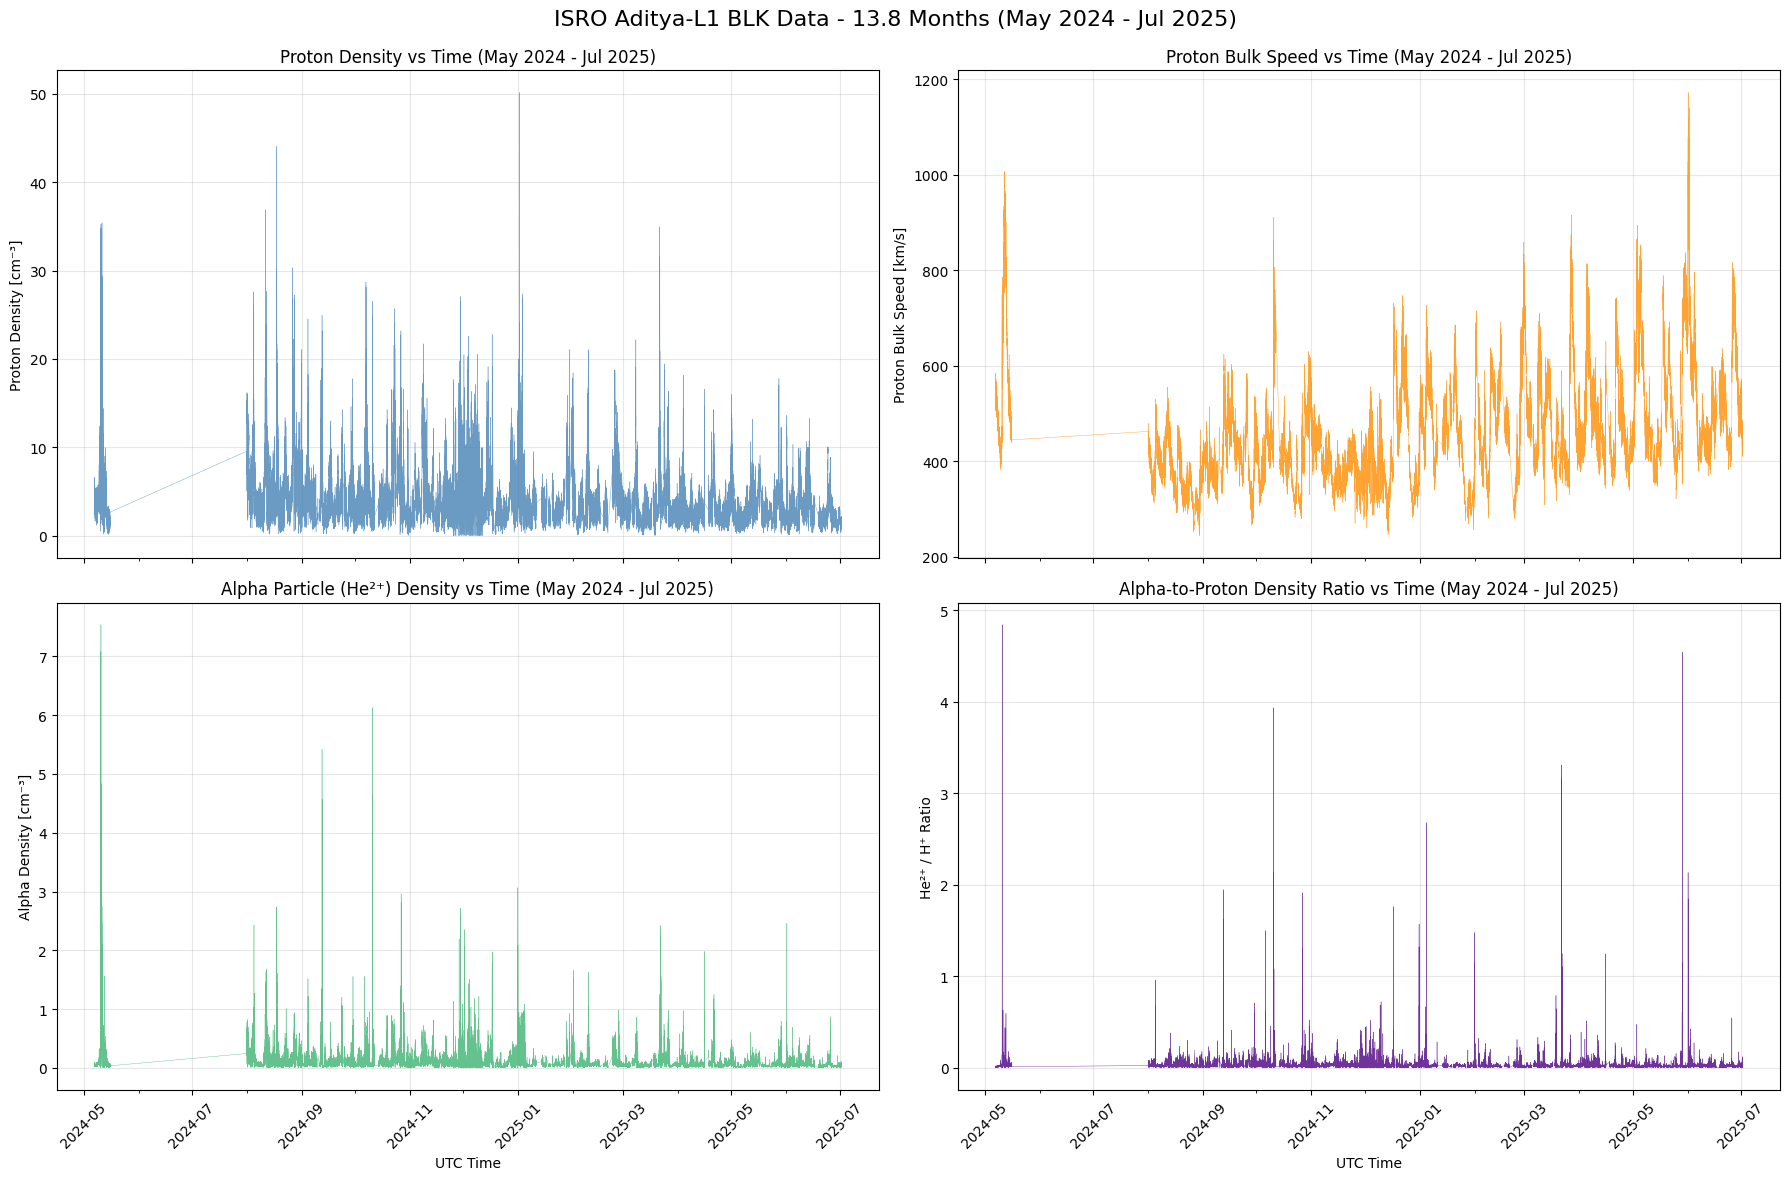


Plot Statistics:
Data points plotted: 2,116,065
Time range (UTC): 2024-05-07 00:03 to 2025-07-01 23:57
Duration: 420 days (13.8 months)


In [27]:
# Plot BLK data with dynamic date range
if 'merged_df' in locals() and len(merged_df) > 0:
    print("Creating comprehensive plots for BLK data with dynamic date range...")

    # Calculate actual date range
    start_date = merged_df['UTC'].min()
    end_date = merged_df['UTC'].max()
    duration_days = (end_date - start_date).days
    duration_months = duration_days / 30.44  # Average days per month

    print(f"Data span: {duration_days} days ({duration_months:.1f} months)")

    # Create figure with adjusted dimensions
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharex=True)

    # Proton Density
    axs[0, 0].plot(merged_df["UTC"], merged_df["Proton_Density"], color='steelblue', linewidth=0.3, alpha=0.8)
    axs[0, 0].set_ylabel("Proton Density [cm⁻³]")
    axs[0, 0].set_title(f"Proton Density vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[0, 0].grid(True, alpha=0.3)

    # Proton Bulk Speed
    axs[0, 1].plot(merged_df["UTC"], merged_df["Proton_Bulk_Speed"], color='darkorange', linewidth=0.3, alpha=0.8)
    axs[0, 1].set_ylabel("Proton Bulk Speed [km/s]")
    axs[0, 1].set_title(f"Proton Bulk Speed vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[0, 1].grid(True, alpha=0.3)

    # Alpha Density
    axs[1, 0].plot(merged_df["UTC"], merged_df["Alpha_Density"], color='mediumseagreen', linewidth=0.3, alpha=0.8)
    axs[1, 0].set_xlabel("UTC Time")
    axs[1, 0].set_ylabel("Alpha Density [cm⁻³]")
    axs[1, 0].set_title(f"Alpha Particle (He²⁺) Density vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[1, 0].grid(True, alpha=0.3)

    # He²⁺ / H⁺ Ratio
    axs[1, 1].plot(merged_df["UTC"], merged_df["He2p_Hp_Ratio"], color='indigo', linewidth=0.3, alpha=0.8)
    axs[1, 1].set_xlabel("UTC Time")
    axs[1, 1].set_ylabel("He²⁺ / H⁺ Ratio")
    axs[1, 1].set_title(f"Alpha-to-Proton Density Ratio vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[1, 1].grid(True, alpha=0.3)

    # Format x-axis based on data duration
    for ax in axs.flat:
        if duration_months > 12:  # More than a year
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
        elif duration_months > 3:  # More than 3 months
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=2))
        else:  # Less than 3 months
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax.xaxis.set_major_locator(mdates.WeekdayLocator())
            ax.xaxis.set_minor_locator(mdates.DayLocator())

        ax.tick_params(axis='x', rotation=45)

    # Adjust layout and title
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"ISRO Aditya-L1 BLK Data - {duration_months:.1f} Months ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})",
                 fontsize=16, y=0.98)
    plt.show()

    # Print some statistics
    print(f"\nPlot Statistics:")
    print(f"Data points plotted: {len(merged_df):,}")
    print(f"Time range (UTC): {start_date.strftime('%Y-%m-%d %H:%M')} to {end_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"Duration: {duration_days} days ({duration_months:.1f} months)")

else:
    print("No merged_df available for plotting!")
    print("Please run the previous cells successfully first.")

Creating comprehensive plots for BLK data with dynamic date range and peak detection...
Data span: 420 days (13.8 months)
Proton_Density: Found 5 peaks
Proton_Bulk_Speed: Found 5 peaks
Alpha_Density: Found 5 peaks
He2p_Hp_Ratio: Found 5 peaks


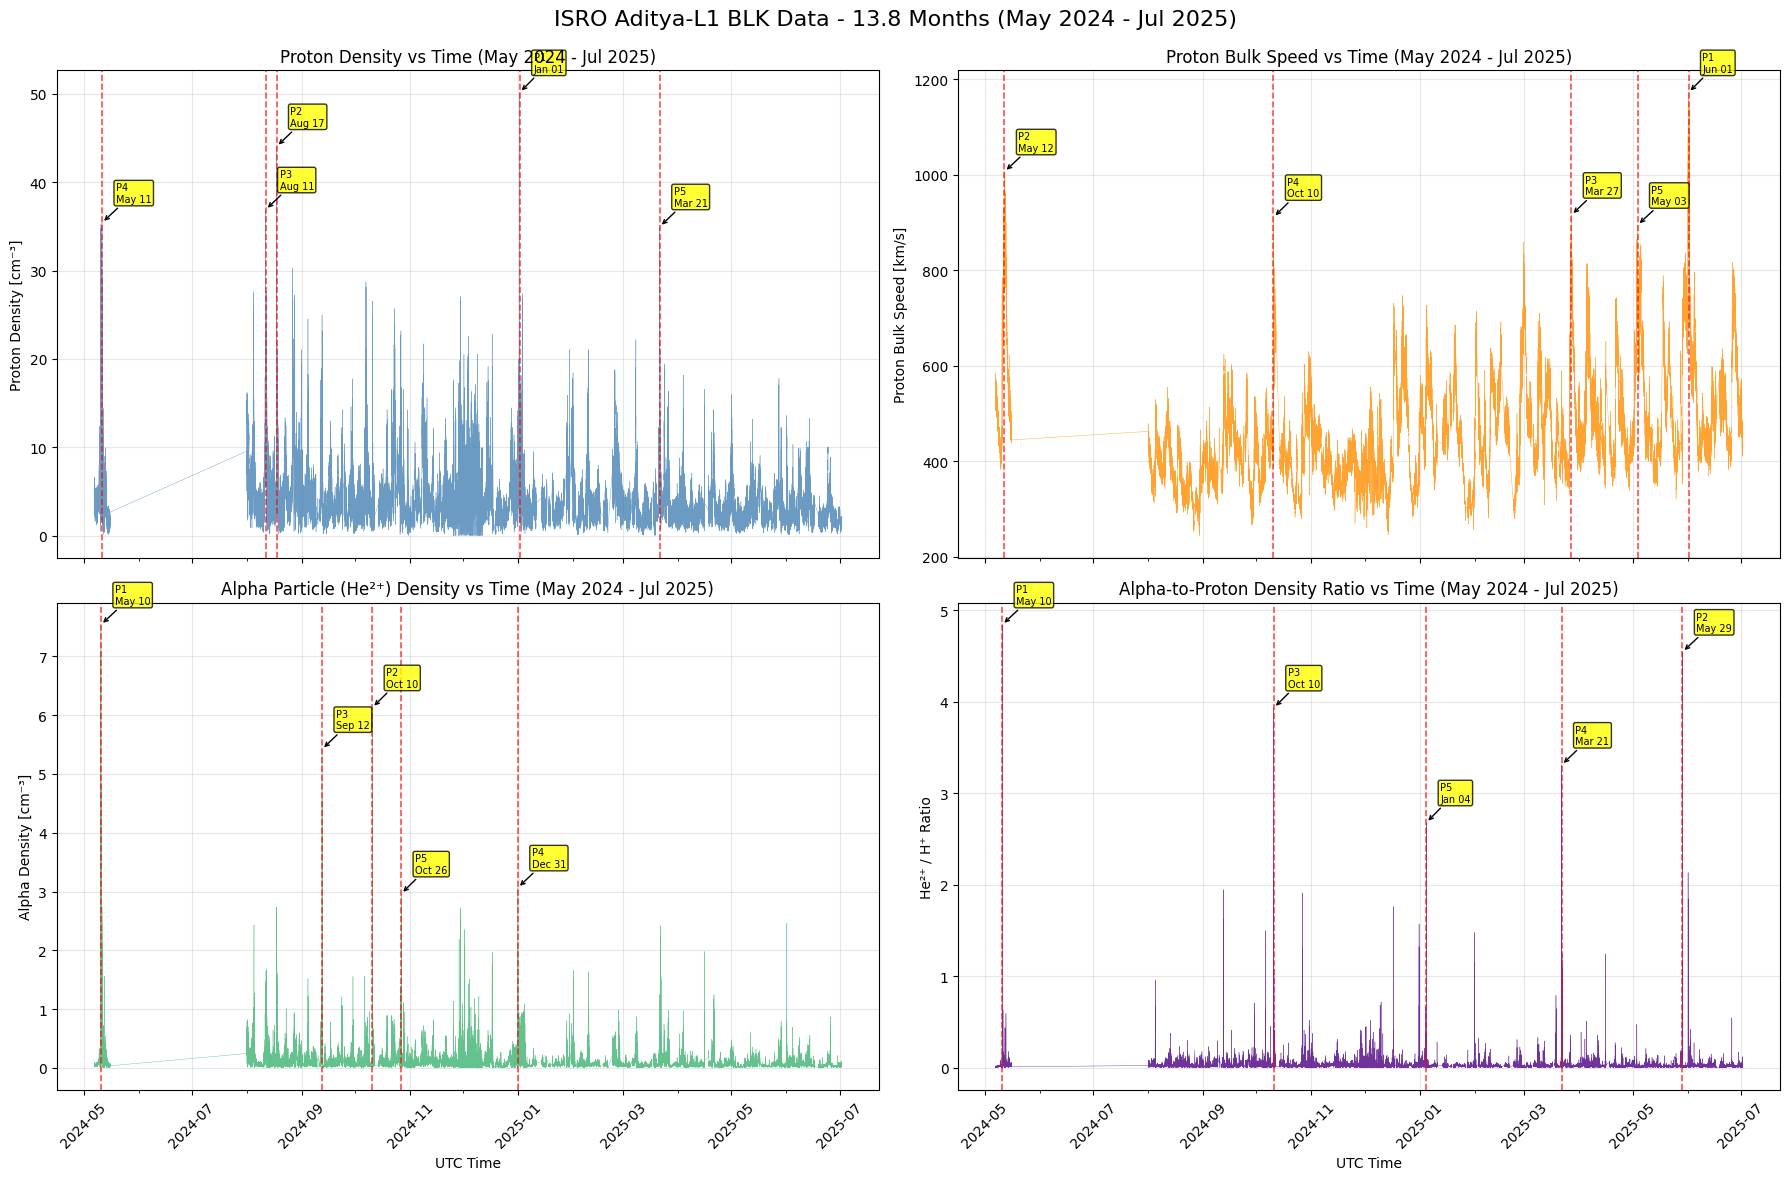


Plot Statistics:
Data points plotted: 2,116,065
Time range (UTC): 2024-05-07 00:03 to 2025-07-01 23:57
Duration: 420 days (13.8 months)

Peak Detection Summary:
Proton_Density:
  Peak 1: 2025-01-01 17:12 UTC - Value: 50.144
  Peak 2: 2024-08-17 16:59 UTC - Value: 44.037
  Peak 3: 2024-08-11 13:28 UTC - Value: 36.887
  Peak 4: 2024-05-11 09:06 UTC - Value: 35.410
  Peak 5: 2025-03-21 15:56 UTC - Value: 34.969
Proton_Bulk_Speed:
  Peak 1: 2025-06-01 12:21 UTC - Value: 1172.728
  Peak 2: 2024-05-12 00:57 UTC - Value: 1006.772
  Peak 3: 2025-03-27 10:56 UTC - Value: 915.838
  Peak 4: 2024-10-10 14:48 UTC - Value: 911.228
  Peak 5: 2025-05-03 18:23 UTC - Value: 894.700
Alpha_Density:
  Peak 1: 2024-05-10 18:24 UTC - Value: 7.539
  Peak 2: 2024-10-10 15:16 UTC - Value: 6.130
  Peak 3: 2024-09-12 08:31 UTC - Value: 5.420
  Peak 4: 2024-12-31 16:10 UTC - Value: 3.065
  Peak 5: 2024-10-26 22:15 UTC - Value: 2.963
He2p_Hp_Ratio:
  Peak 1: 2024-05-10 18:24 UTC - Value: 4.844
  Peak 2: 2025-05-29

In [28]:
# Plot BLK data with dynamic date range and peak detection
if 'merged_df' in locals() and len(merged_df) > 0:
    print("Creating comprehensive plots for BLK data with dynamic date range and peak detection...")

    # Import scipy for peak detection
    from scipy.signal import find_peaks

    # Calculate actual date range
    start_date = merged_df['UTC'].min()
    end_date = merged_df['UTC'].max()
    duration_days = (end_date - start_date).days
    duration_months = duration_days / 30.44  # Average days per month

    print(f"Data span: {duration_days} days ({duration_months:.1f} months)")

    # Create figure with adjusted dimensions
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharex=True)

    # Define the variables and their corresponding axes
    plot_configs = [
        ('Proton_Density', axs[0, 0], 'steelblue', "Proton Density [cm⁻³]", f"Proton Density vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})"),
        ('Proton_Bulk_Speed', axs[0, 1], 'darkorange', "Proton Bulk Speed [km/s]", f"Proton Bulk Speed vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})"),
        ('Alpha_Density', axs[1, 0], 'mediumseagreen', "Alpha Density [cm⁻³]", f"Alpha Particle (He²⁺) Density vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})"),
        ('He2p_Hp_Ratio', axs[1, 1], 'indigo', "He²⁺ / H⁺ Ratio", f"Alpha-to-Proton Density Ratio vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    ]

    # Function to find top peaks (adjusted for larger datasets)
    def find_top_peaks(data, n_peaks=5):  # Increased to 5 peaks for longer datasets
        # Remove NaN values for peak detection
        valid_indices = ~np.isnan(data)
        valid_data = data[valid_indices]
        valid_idx = np.where(valid_indices)[0]

        if len(valid_data) < 10:
            return []

        # Adjust minimum distance based on dataset size
        min_distance = max(len(valid_data) // 100, 50)  # More spacing for larger datasets
        peaks, properties = find_peaks(valid_data, distance=min_distance, prominence=np.std(valid_data)*0.5)

        if len(peaks) == 0:
            return []

        # Get peak heights and sort by height to get top peaks
        peak_heights = valid_data[peaks]
        top_peak_indices = np.argsort(peak_heights)[-n_peaks:][::-1]

        return valid_idx[peaks[top_peak_indices]]

    # Plot each variable and add peak annotations
    for var_name, ax, color, ylabel, title in plot_configs:
        # Plot the main data
        ax.plot(merged_df["UTC"], merged_df[var_name], color=color, linewidth=0.3, alpha=0.8)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

        # Find top peaks
        peak_indices = find_top_peaks(merged_df[var_name].values)

        # Add vertical dotted lines and annotations for peaks
        for i, peak_idx in enumerate(peak_indices):
            peak_date = merged_df.iloc[peak_idx]["UTC"]
            peak_value = merged_df.iloc[peak_idx][var_name]

            # Add vertical dotted line
            ax.axvline(x=peak_date, color='red', linestyle='--', alpha=0.7, linewidth=1.2)

            # Add annotation with peak index and date
            ax.annotate(f'P{i+1}\n{peak_date.strftime("%b %d")}',
                       xy=(peak_date, peak_value),
                       xytext=(10, 15), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.8),
                       fontsize=7, ha='left',
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        print(f"{var_name}: Found {len(peak_indices)} peaks")

    # Set x-axis labels for bottom row
    axs[1, 0].set_xlabel("UTC Time")
    axs[1, 1].set_xlabel("UTC Time")

    # Format x-axis based on data duration
    for ax in axs.flat:
        if duration_months > 12:  # More than a year
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
        elif duration_months > 3:  # More than 3 months
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=2))
        else:  # Less than 3 months
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax.xaxis.set_major_locator(mdates.WeekdayLocator())
            ax.xaxis.set_minor_locator(mdates.DayLocator())

        ax.tick_params(axis='x', rotation=45)

    # Adjust layout and title
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"ISRO Aditya-L1 BLK Data - {duration_months:.1f} Months ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})",
                 fontsize=16, y=0.98)
    plt.show()

    # Print detailed statistics
    print(f"\nPlot Statistics:")
    print(f"Data points plotted: {len(merged_df):,}")
    print(f"Time range (UTC): {start_date.strftime('%Y-%m-%d %H:%M')} to {end_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"Duration: {duration_days} days ({duration_months:.1f} months)")

    # Peak detection summary
    print(f"\nPeak Detection Summary:")
    for var_name, _, _, _, _ in plot_configs:
        peak_indices = find_top_peaks(merged_df[var_name].values)
        if len(peak_indices) > 0:
            print(f"{var_name}:")
            for i, peak_idx in enumerate(peak_indices):
                peak_date = merged_df.iloc[peak_idx]["UTC"]
                peak_value = merged_df.iloc[peak_idx][var_name]
                print(f"  Peak {i+1}: {peak_date.strftime('%Y-%m-%d %H:%M')} UTC - Value: {peak_value:.3f}")
        else:
            print(f"{var_name}: No significant peaks detected")

else:
    print("No merged_df available for plotting!")
    print("Please run the previous cells successfully first.")

Creating enhanced plots with metadata-driven labels and error bars...
Data span: 420 days (13.8 months)
Proton_Density: Found 5 peaks
Proton_Bulk_Speed: Found 5 peaks
Alpha_Density: Found 5 peaks
He2p_Hp_Ratio: Found 5 peaks


/tmp/ipython-input-29-3903342493.py:156: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


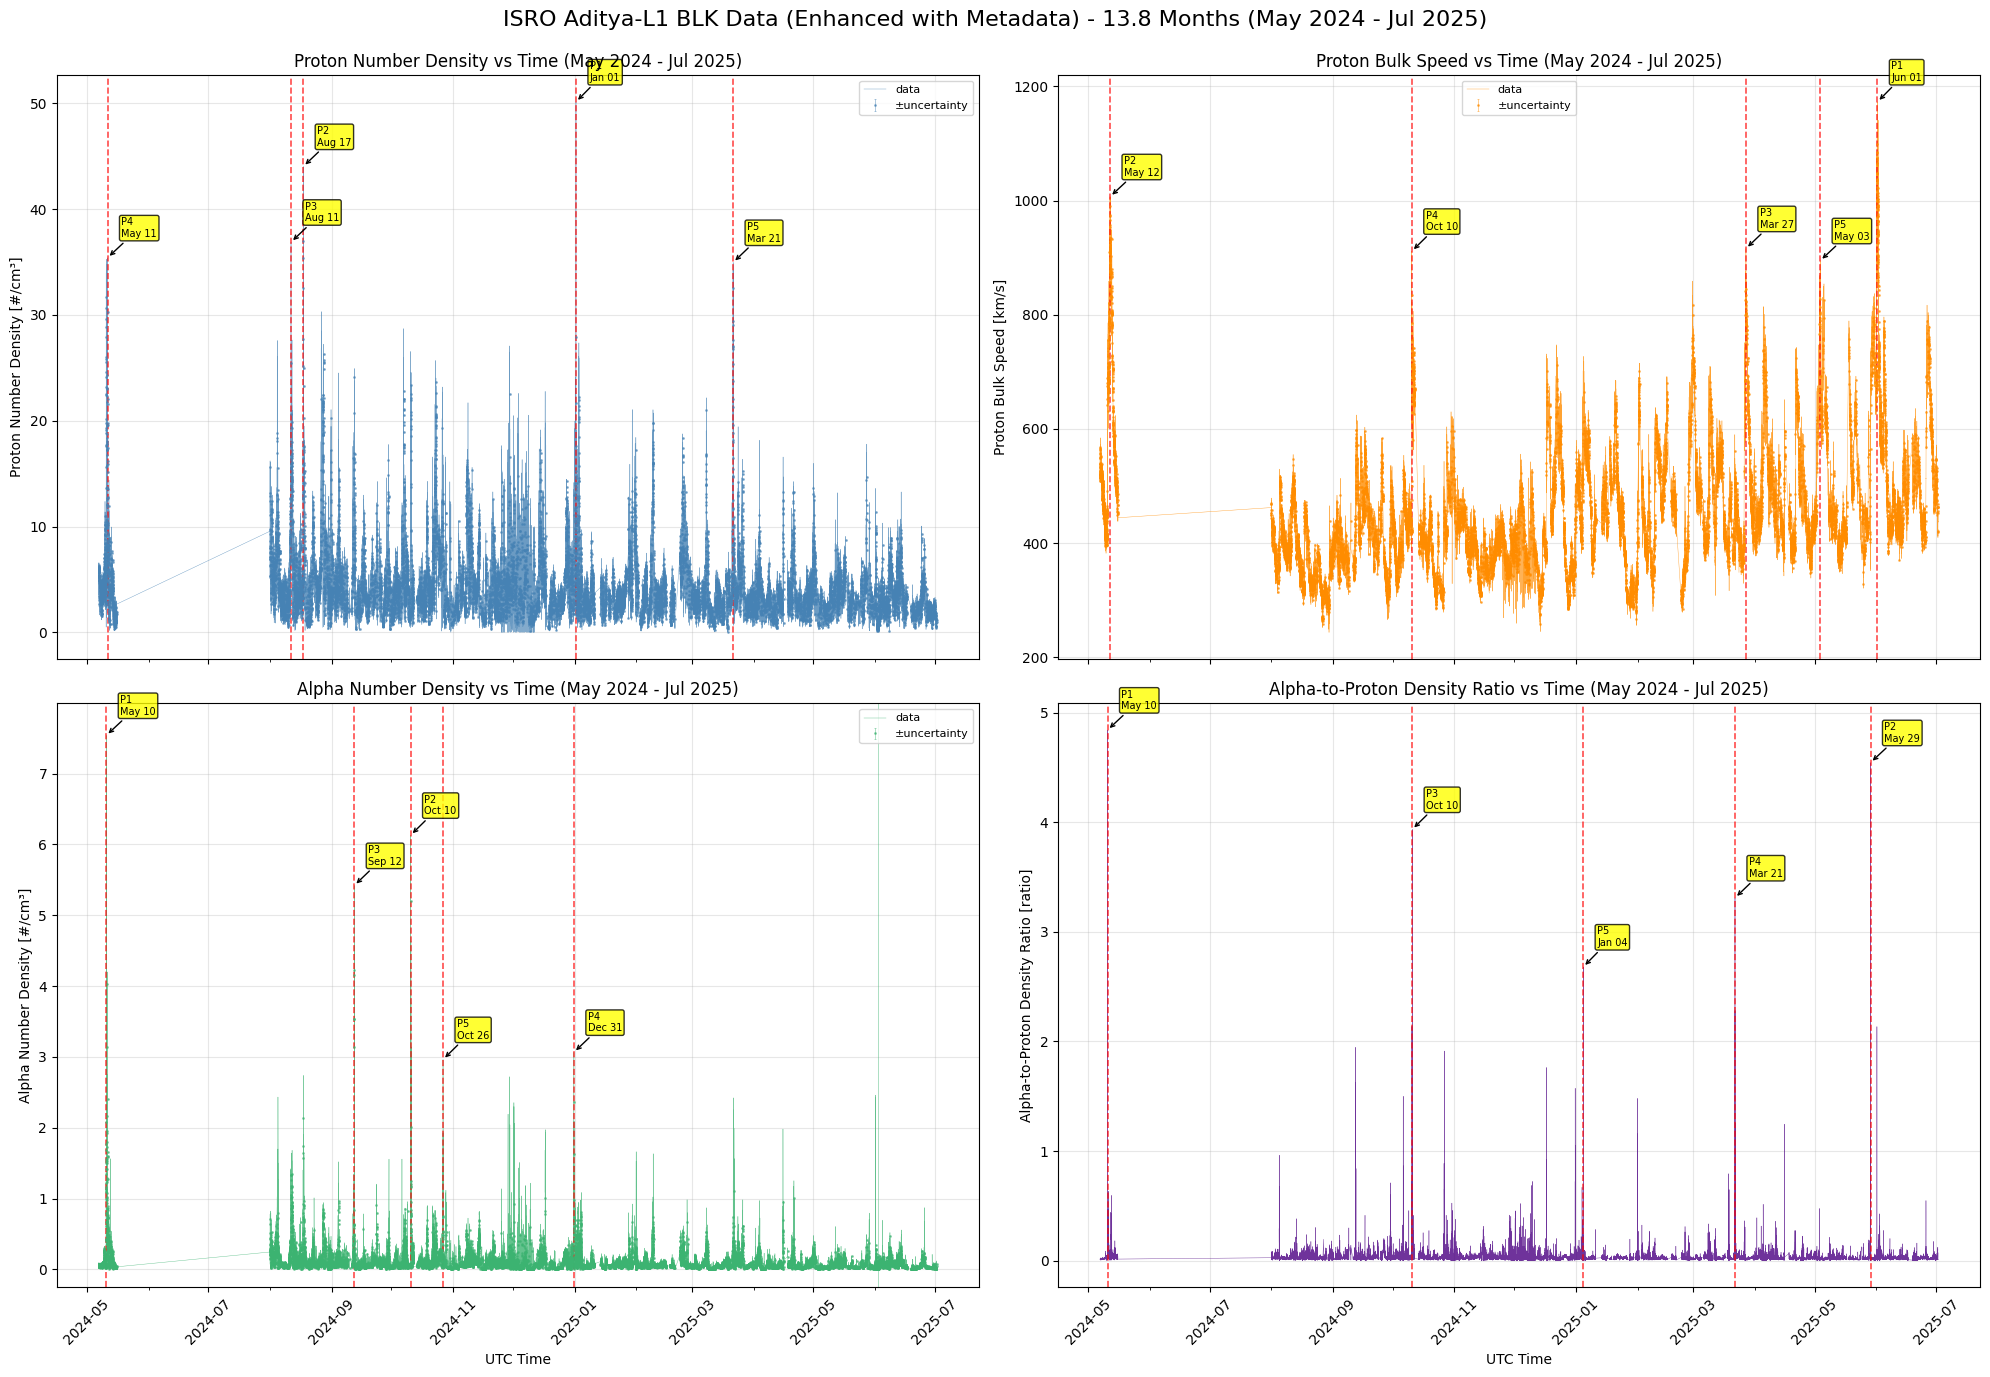


Enhanced Plot Statistics:
Data points plotted: 2,116,065
Time range (UTC): 2024-05-07 00:03 to 2025-07-01 23:57
Duration: 420 days (13.8 months)

Uncertainty data available for:
  Proton_Density: ±inf (mean uncertainty)
  Proton_Bulk_Speed: ±inf (mean uncertainty)
  Alpha_Density: ±inf (mean uncertainty)
  Proton_X_Velocity: ±inf (mean uncertainty)
  Proton_Y_Velocity: ±inf (mean uncertainty)
  Proton_Z_Velocity: ±inf (mean uncertainty)
  Proton_Thermal: ±inf (mean uncertainty)
  Alpha_Bulk_Speed: ±inf (mean uncertainty)
  Alpha_Thermal: ±inf (mean uncertainty)

Peak Detection Summary (Metadata-Enhanced):
Proton Number Density:
  Peak 1: 2025-01-01 17:12 UTC - Value: 50.14 #/cm³
  Peak 2: 2024-08-17 16:59 UTC - Value: 44.04 #/cm³
  Peak 3: 2024-08-11 13:28 UTC - Value: 36.89 #/cm³
  Peak 4: 2024-05-11 09:06 UTC - Value: 35.41 #/cm³
  Peak 5: 2025-03-21 15:56 UTC - Value: 34.97 #/cm³
Proton Bulk Speed:
  Peak 1: 2025-06-01 12:21 UTC - Value: 1172.73 km/s
  Peak 2: 2024-05-12 00:57 UTC 

In [29]:
# Enhanced plotting with metadata-driven labels and error bars
if 'merged_df' in locals() and len(merged_df) > 0:
    print("Creating enhanced plots with metadata-driven labels and error bars...")

    # Import scipy for peak detection
    from scipy.signal import find_peaks

    # Calculate actual date range
    start_date = merged_df['UTC'].min()
    end_date = merged_df['UTC'].max()
    duration_days = (end_date - start_date).days
    duration_months = duration_days / 30.44

    print(f"Data span: {duration_days} days ({duration_months:.1f} months)")

    # Create enhanced figure with error bars
    fig, axs = plt.subplots(2, 2, figsize=(20, 14), sharex=True)

    # Enhanced plot configurations using metadata
    plot_configs = [
        {
            'var': 'Proton_Density',
            'ax': axs[0, 0],
            'color': 'steelblue',
            'config': VARIABLE_CONFIG['proton_density']
        },
        {
            'var': 'Proton_Bulk_Speed',
            'ax': axs[0, 1],
            'color': 'darkorange',
            'config': VARIABLE_CONFIG['proton_bulk_speed']
        },
        {
            'var': 'Alpha_Density',
            'ax': axs[1, 0],
            'color': 'mediumseagreen',
            'config': VARIABLE_CONFIG['alpha_density']
        },
        {
            'var': 'He2p_Hp_Ratio',
            'ax': axs[1, 1],
            'color': 'indigo',
            'config': {'label': 'Alpha-to-Proton Density Ratio', 'units': 'ratio'}
        }
    ]

    # Function to find top peaks (adjusted for larger datasets)
    def find_top_peaks(data, n_peaks=5):
        valid_indices = ~np.isnan(data)
        valid_data = data[valid_indices]
        valid_idx = np.where(valid_indices)[0]

        if len(valid_data) < 10:
            return []

        min_distance = max(len(valid_data) // 100, 50)
        peaks, properties = find_peaks(valid_data, distance=min_distance, prominence=np.std(valid_data)*0.5)

        if len(peaks) == 0:
            return []

        peak_heights = valid_data[peaks]
        top_peak_indices = np.argsort(peak_heights)[-n_peaks:][::-1]

        return valid_idx[peaks[top_peak_indices]]

    # Plot each variable with enhanced metadata
    for plot_config in plot_configs:
        var_name = plot_config['var']
        ax = plot_config['ax']
        color = plot_config['color']
        config = plot_config['config']

        if var_name in merged_df.columns:
            y_data = merged_df[var_name]
            x_data = merged_df['UTC']
             # Filter out fill values
            fillval = config.get('fillval', -1e31)
            valid_mask = (y_data != fillval) & np.isfinite(y_data)
            x_data = x_data[valid_mask]
            y_data = y_data[valid_mask]

            # Custom fix for Alpha Density scaling
            if var_name == 'Alpha_Density':
                # Force y-axis zoom range
                ax.set_ylim(-0.25, 7.99)  # Adjust as needed for Alpha Density
            # Check for uncertainty data
            uncertainty_col = var_name + '_Uncertainty'
            if uncertainty_col in merged_df.columns:
                y_err = merged_df[uncertainty_col]
                # Plot with error bars (sample every 100th point for readability)
                mask = np.arange(len(x_data)) % 100 == 0
                ax.errorbar(x_data[mask], y_data[mask], yerr=y_err[mask],
                           fmt='o', color=color, alpha=0.6, markersize=1,
                           capsize=1, capthick=0.5, elinewidth=0.5, label='±uncertainty')
                # Plot main line
                ax.plot(x_data, y_data, color=color, linewidth=0.3, alpha=0.8, label='data')
                ax.legend(fontsize=8)
            else:
                # Plot without error bars
                ax.plot(x_data, y_data, color=color, linewidth=0.3, alpha=0.8)

            # Set labels using metadata
            ylabel = f"{config['label']} [{config['units']}]"
            title = f"{config['label']} vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})"

            ax.set_ylabel(ylabel)
            ax.set_title(title)
            ax.grid(True, alpha=0.3)

            # Find and annotate peaks
            peak_indices = find_top_peaks(y_data.values)
            for i, peak_idx in enumerate(peak_indices):
                peak_date = merged_df.iloc[peak_idx]["UTC"]
                peak_value = merged_df.iloc[peak_idx][var_name]

                # Add vertical dotted line
                ax.axvline(x=peak_date, color='red', linestyle='--', alpha=0.7, linewidth=1.2)

                # Add annotation with peak info
                ax.annotate(f'P{i+1}\n{peak_date.strftime("%b %d")}',
                           xy=(peak_date, peak_value),
                           xytext=(10, 15), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.8),
                           fontsize=7, ha='left',
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

            print(f"{var_name}: Found {len(peak_indices)} peaks")
        else:
            ax.text(0.5, 0.5, f'{var_name}\nNot Available',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{config['label']} (No Data)")

    # Set x-axis labels for bottom row
    axs[1, 0].set_xlabel("UTC Time")
    axs[1, 1].set_xlabel("UTC Time")

    # Format x-axis based on data duration
    for ax in axs.flat:
        if duration_months > 12:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
        elif duration_months > 3:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=2))
        else:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax.xaxis.set_major_locator(mdates.WeekdayLocator())
            ax.xaxis.set_minor_locator(mdates.DayLocator())

        ax.tick_params(axis='x', rotation=45)

    # Adjust layout and title
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"ISRO Aditya-L1 BLK Data (Enhanced with Metadata) - {duration_months:.1f} Months ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})",
                 fontsize=16, y=0.98)
    plt.show()

    # Enhanced statistics with metadata
    print(f"\nEnhanced Plot Statistics:")
    print(f"Data points plotted: {len(merged_df):,}")
    print(f"Time range (UTC): {start_date.strftime('%Y-%m-%d %H:%M')} to {end_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"Duration: {duration_days} days ({duration_months:.1f} months)")

    # Uncertainty information
    uncertainty_vars = [col for col in merged_df.columns if col.endswith('_Uncertainty')]
    if uncertainty_vars:
        print(f"\nUncertainty data available for:")
        for unc_var in uncertainty_vars:
            base_var = unc_var.replace('_Uncertainty', '')
            if base_var in merged_df.columns:
                valid_unc = merged_df[unc_var].dropna()
                if len(valid_unc) > 0:
                    mean_unc = valid_unc.mean()
                    print(f"  {base_var}: ±{mean_unc:.3f} (mean uncertainty)")

    # Peak detection summary with metadata
    print(f"\nPeak Detection Summary (Metadata-Enhanced):")
    for plot_config in plot_configs:
        var_name = plot_config['var']
        config = plot_config['config']

        if var_name in merged_df.columns:
            peak_indices = find_top_peaks(merged_df[var_name].values)
            if len(peak_indices) > 0:
                print(f"{config['label']}:")
                for i, peak_idx in enumerate(peak_indices):
                    peak_date = merged_df.iloc[peak_idx]["UTC"]
                    peak_value = merged_df.iloc[peak_idx][var_name]

                    # Format with proper significant digits
                    sig_digits = config.get('sig_digits', 3)
                    formatted_value = round(peak_value, sig_digits)

                    print(f"  Peak {i+1}: {peak_date.strftime('%Y-%m-%d %H:%M')} UTC - Value: {formatted_value} {config['units']}")
            else:
                print(f"{config['label']}: No significant peaks detected")

else:
    print("No merged_df available for enhanced plotting!")
    print("Please run the previous cells successfully first.")

# 3D Visual of aditya L1 in space

In [30]:
# # 3D Visualization of Aditya-L1 Halo Orbit in Space
# if 'merged_df' in locals() and len(merged_df) > 0:
#     print("Creating 3D visualization of Aditya-L1 orbit...")

#     from mpl_toolkits.mplot3d import Axes3D

#     # Check if spacecraft position data is available
#     pos_columns = ['Spacecraft_X_Pos', 'Spacecraft_Y_Pos', 'Spacecraft_Z_Pos']
#     if all(col in merged_df.columns for col in pos_columns):
#         # Load spacecraft position arrays (convert to km if needed)
#         x = merged_df["Spacecraft_X_Pos"].dropna()
#         y = merged_df["Spacecraft_Y_Pos"].dropna()
#         z = merged_df["Spacecraft_Z_Pos"].dropna()

#         if len(x) > 0 and len(y) > 0 and len(z) > 0:
#             # Create enhanced 3D plot
#             fig = plt.figure(figsize=(12, 10))
#             ax = fig.add_subplot(111, projection='3d')

#             # Plot the orbit trajectory
#             ax.plot(x, y, z, label="Aditya-L1 Halo Orbit", color='orange', linewidth=1.5, alpha=0.8)

#             # Mark start and end points
#             ax.scatter(x.iloc[0], y.iloc[0], z.iloc[0], color='green', s=100, label='Start Position', marker='o')
#             ax.scatter(x.iloc[-1], y.iloc[-1], z.iloc[-1], color='red', s=100, label='End Position', marker='s')

#             # Add Earth at origin (make it larger and more visible)
#             ax.scatter(0, 0, 0, color='blue', s=500, label='Earth', marker='o', edgecolors='black', linewidth=2)

#             # Add L1 point (approximately 1.5 million km from Earth towards Sun)
#             ax.scatter(1.5e6, 0, 0, color='red', s=300, label='L1 Point', marker='^', edgecolors='black', linewidth=1)

#             # Don't add Sun as it's too far away (150M km) - would make plot unreadable
#             # Instead, add an arrow indicating Sun direction
#             ax.text(x.max(), y.max(), z.max(), 'Sun →', fontsize=12, color='orange', weight='bold')

#             # Set labels with proper units
#             ax.set_xlabel("X-GSE (km)")
#             ax.set_ylabel("Y-GSE (km)")
#             ax.set_zlabel("Z-GSE (km)")
#             ax.set_title("Aditya-L1 Halo Orbit in GSE Coordinates\n" +
#                         f"Data from {merged_df['UTC'].min().strftime('%Y-%m-%d')} to {merged_df['UTC'].max().strftime('%Y-%m-%d')}")

#             # Improve visualization
#             ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
#             ax.grid(True, alpha=0.3)

#             # Set axis limits to include Earth and show good view of orbit
#             # Calculate orbit extent
#             orbit_x_range = x.max() - x.min()
#             orbit_y_range = y.max() - y.min()
#             orbit_z_range = z.max() - z.min()

#             # Expand range to include Earth at origin and provide good visibility
#             x_padding = max(orbit_x_range * 0.1, 100000)  # At least 100,000 km padding
#             y_padding = max(orbit_y_range * 0.1, 100000)
#             z_padding = max(orbit_z_range * 0.1, 100000)

#             # Set limits that include both Earth (0,0,0) and the full orbit
#             ax.set_xlim(min(0 - x_padding, x.min() - x_padding), max(x.max() + x_padding, 1.6e6))
#             ax.set_ylim(min(0 - y_padding, y.min() - y_padding), max(y.max() + y_padding, 0 + y_padding))
#             ax.set_zlim(min(0 - z_padding, z.min() - z_padding), max(z.max() + z_padding, 0 + z_padding))

#             plt.tight_layout()
#             plt.show()

#             # Print orbit statistics
#             print(f"\nAditya-L1 Orbit Statistics:")
#             print(f"  Position data points: {len(x):,}")
#             print(f"  X-GSE range: {x.min():.0f} to {x.max():.0f} km")
#             print(f"  Y-GSE range: {y.min():.0f} to {y.max():.0f} km")
#             print(f"  Z-GSE range: {z.min():.0f} to {z.max():.0f} km")

#             # Calculate distance from Earth
#             distance_from_earth = np.sqrt(x**2 + y**2 + z**2)
#             print(f"  Distance from Earth: {distance_from_earth.min():.0f} to {distance_from_earth.max():.0f} km")
#             print(f"  Mean distance from Earth: {distance_from_earth.mean():.0f} km")

#             # Calculate distance from L1 point
#             distance_from_l1 = np.sqrt((x - 1.5e6)**2 + y**2 + z**2)
#             print(f"  Distance from L1 point: {distance_from_l1.min():.0f} to {distance_from_l1.max():.0f} km")
#             print(f"  Mean distance from L1: {distance_from_l1.mean():.0f} km")

#         else:
#             print("No valid spacecraft position data available for plotting.")
#     else:
#         print("Spacecraft position columns not found in the dataset.")
#         print(f"Available columns: {list(merged_df.columns)}")
# else:
#     print("No merged_df available for 3D orbit visualization!")
#     print("Please run the previous cells successfully first.")


# Loading dates from CME catalogues

In [32]:
# Importing xl files for CME catalogue data

helcats_xls = pd.ExcelFile("/content/data2/dataset/catalogue/HelCats.xlsx")
helcats_df = pd.read_excel(helcats_xls, sheet_name="HelCats")
Soho_xls = pd.ExcelFile("/content/data2/dataset/catalogue/Soho.xlsx")
soho_df = pd.read_excel(Soho_xls, sheet_name="Soho")
RnC_xls = pd.ExcelFile("/content/data2/dataset/catalogue/RnC.xlsx")
rnc_df = pd.read_excel(RnC_xls, sheet_name="RnC")

In [33]:
# Helcats : convert 'SSE Launch' to datetime and create 'dates' column

# Specify the date format to avoid the warning and improve performance
helcats_df['date'] = pd.to_datetime(helcats_df['SSE Launch'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Create a new 'dates' column with only dates in YYYY/MM/DD format
helcats_df['dates'] = helcats_df['date'].dt.strftime('%Y/%m/%d')

# print('Helcats Dates \n',helcats_df['dates'].head(), '\n\n')





# Soho : convert 'First C2 Appearance' to datetime and create 'dates' column

# Specify the date format to avoid the warning and improve performance
soho_df['date'] = pd.to_datetime(soho_df['First C2 Appearance'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Create a new 'dates' column with only dates in YYYY/MM/DD format
soho_df['dates'] = soho_df['date'].dt.strftime('%Y/%m/%d')

# print('\nSoho Dates \n', soho_df['dates'].head())




# RnC : convert 'Disturbance Y/M/D (UT) ' to datetime and create 'dates' column

# RnC data has format like '2024/01/03 1510' - need to handle this specific format
def parse_rnc_date(date_str):
    if pd.isna(date_str) or date_str is None:
        return pd.NaT
    try:
        # Convert to string and strip whitespace
        date_str = str(date_str).strip()

        # Check if there's a space separator
        if ' ' in date_str:
            parts = date_str.split(' ')
            if len(parts) >= 2:
                date_part = parts[0]
                time_part = parts[1]

                # Convert HHMM to HH:MM if it's 4 digits
                if len(time_part) == 4 and time_part.isdigit():
                    time_formatted = f"{time_part[:2]}:{time_part[2:]}"
                    full_date_str = f"{date_part} {time_formatted}"
                    return pd.to_datetime(full_date_str, format='%Y/%m/%d %H:%M')

        # Try parsing as-is as fallback
        return pd.to_datetime(date_str, errors='coerce')
    except Exception:
        return pd.NaT

# Apply the custom parsing function
rnc_df['date'] = rnc_df['Disturbance Y/M/D (UT)\xa0'].apply(parse_rnc_date)

# Create a new 'dates' column with only dates in YYYY/MM/DD format
rnc_df['dates'] = rnc_df['date'].dt.strftime('%Y/%m/%d')

# print('\nRnC Dates \n', rnc_df['dates'].head()

In [35]:
# Combine dates from all catalogues into a single DataFrame
dates_combined = pd.DataFrame({
    'Helcats': helcats_df['dates'],
    'Soho': soho_df['dates'],
    'RnC': rnc_df['dates']})

# Print the first few rows of the combined dates DataFrame
print("\nCombined Dates from All Catalogues:")
print(dates_combined.head())
print(dates_combined.columns)




Combined Dates from All Catalogues:
      Helcats        Soho         RnC
0         NaN         NaN         NaN
1  2025/05/31         NaN         NaN
2  2025/05/31  2025/01/22  2024/01/03
3  2025/05/30  2025/01/24  2024/01/23
4  2025/05/27  2025/02/02  2024/01/26
Index(['Helcats', 'Soho', 'RnC'], dtype='object')


In [36]:
# Clean and analyze the combined dates
print("\nAnalyzing combined catalogue dates...")

# Remove NaN values and get unique dates for each catalogue
helcats_dates_clean = set(helcats_df['dates'].dropna().unique())
soho_clean = set(soho_df['dates'].dropna().unique())
rnc_dates_clean = set(rnc_df['dates'].dropna().unique())

print(f"Unique dates after cleaning:")
print(f"  HelCats: {len(helcats_dates_clean)} unique dates")
print(f"  SOHO: {len(soho_clean)} unique dates")
print(f"  RnC: {len(rnc_dates_clean)} unique dates")

# Find min and max dates for RnC
rnc_valid_dates = rnc_df['dates'].dropna()
if len(rnc_valid_dates) > 0:
    rnc_min_date = rnc_valid_dates.min()
    rnc_max_date = rnc_valid_dates.max()
    print(f"\nRnC date range:")
    print(f"  Min date: {rnc_min_date}")
    print(f"  Max date: {rnc_max_date}")
else:
    print("\nNo valid RnC dates found")

# Find common dates between catalogues
helcats_soho_common = helcats_dates_clean.intersection(soho_clean)
helcats_rnc_common = helcats_dates_clean.intersection(rnc_dates_clean)
soho_rnc_common = soho_clean.intersection(rnc_dates_clean)
all_common = helcats_dates_clean.intersection(soho_clean).intersection(rnc_dates_clean)

print(f"\nCommon dates between catalogues:")
print(f"  HelCats & SOHO: {len(helcats_soho_common)} dates")
print(f"  HelCats & RnC: {len(helcats_rnc_common)} dates")
print(f"  SOHO & RnC: {len(soho_rnc_common)} dates")
print(f"  All three: {len(all_common)} dates")

if len(helcats_rnc_common) > 0:
    rnc_helcats_common_dates = sorted(list(helcats_rnc_common))
    print(f"\nHelCats & RnC common dates: {rnc_helcats_common_dates}")


Analyzing combined catalogue dates...
Unique dates after cleaning:
  HelCats: 173 unique dates
  SOHO: 53 unique dates
  RnC: 28 unique dates

RnC date range:
  Min date: 2024/01/03
  Max date: 2024/12/31

Common dates between catalogues:
  HelCats & SOHO: 40 dates
  HelCats & RnC: 10 dates
  SOHO & RnC: 5 dates
  All three: 4 dates

HelCats & RnC common dates: ['2024/05/10', '2024/05/12', '2024/05/17', '2024/07/15', '2024/07/23', '2024/08/31', '2024/09/02', '2024/10/08', '2024/10/12', '2024/12/17']


## Plotting dates

Creating comprehensive plots for BLK data with dynamic date range...
Data span: 420 days (13.8 months)
CME Events in data range:
  HelCats: 173 events
  SOHO: 62 events
  RnC: 21 events


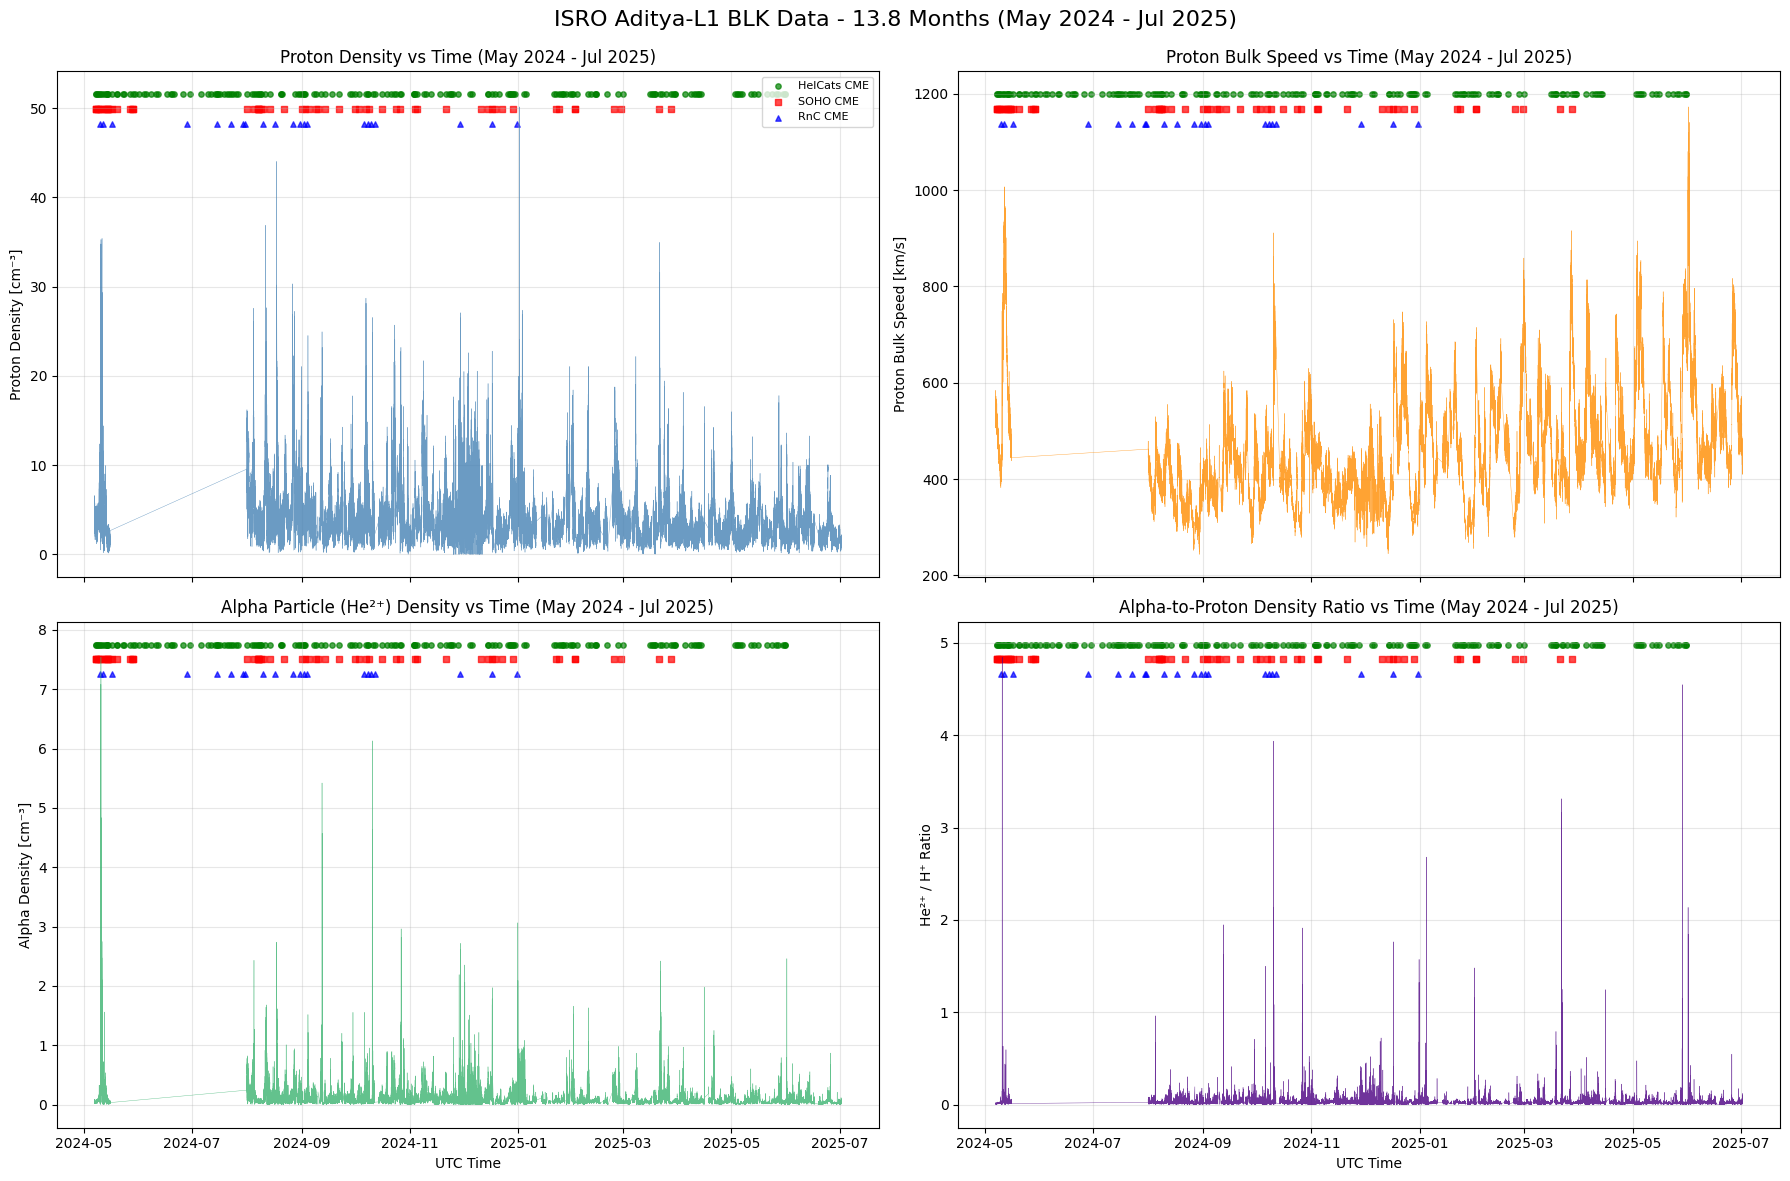


Plot Statistics:
Data points plotted: 2,116,065
Time range (UTC): 2024-05-07 00:03 to 2025-07-01 23:57
Duration: 420 days (13.8 months)


In [37]:
# Plot BLK data with dynamic date range
if 'merged_df' in locals() and len(merged_df) > 0:
    print("Creating comprehensive plots for BLK data with dynamic date range...")

    # Calculate actual date range
    start_date = merged_df['UTC'].min()
    end_date = merged_df['UTC'].max()
    duration_days = (end_date - start_date).days
    duration_months = duration_days / 30.44  # Average days per month

    print(f"Data span: {duration_days} days ({duration_months:.1f} months)")

    # Create figure with adjusted dimensions
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharex=True)

    # Proton Density
    axs[0, 0].plot(merged_df["UTC"], merged_df["Proton_Density"], color='steelblue', linewidth=0.3, alpha=0.8)
    axs[0, 0].set_ylabel("Proton Density [cm⁻³]")
    axs[0, 0].set_title(f"Proton Density vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[0, 0].grid(True, alpha=0.3)

    # Proton Bulk Speed
    axs[0, 1].plot(merged_df["UTC"], merged_df["Proton_Bulk_Speed"], color='darkorange', linewidth=0.3, alpha=0.8)
    axs[0, 1].set_ylabel("Proton Bulk Speed [km/s]")
    axs[0, 1].set_title(f"Proton Bulk Speed vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[0, 1].grid(True, alpha=0.3)

    # Alpha Density
    axs[1, 0].plot(merged_df["UTC"], merged_df["Alpha_Density"], color='mediumseagreen', linewidth=0.3, alpha=0.8)
    axs[1, 0].set_xlabel("UTC Time")
    axs[1, 0].set_ylabel("Alpha Density [cm⁻³]")
    axs[1, 0].set_title(f"Alpha Particle (He²⁺) Density vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[1, 0].grid(True, alpha=0.3)

    # He²⁺ / H⁺ Ratio
    axs[1, 1].plot(merged_df["UTC"], merged_df["He2p_Hp_Ratio"], color='indigo', linewidth=0.3, alpha=0.8)
    axs[1, 1].set_xlabel("UTC Time")
    axs[1, 1].set_ylabel("He²⁺ / H⁺ Ratio")
    axs[1, 1].set_title(f"Alpha-to-Proton Density Ratio vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})")
    axs[1, 1].grid(True, alpha=0.3)
    # Extract all unique dates from the combined CME catalogues
    helcats_dates = pd.to_datetime(dates_combined['Helcats'].dropna(), format='%Y/%m/%d', errors='coerce')
    soho_dates = pd.to_datetime(dates_combined['Soho'].dropna(), format='%Y/%m/%d', errors='coerce')
    rnc_dates = pd.to_datetime(dates_combined['RnC'].dropna(), format='%Y/%m/%d', errors='coerce')

    # Filter dates to match the data time range
    data_start = merged_df['UTC'].min()
    data_end = merged_df['UTC'].max()

    helcats_in_range = helcats_dates[(helcats_dates >= data_start) & (helcats_dates <= data_end)]
    soho_in_range = soho_dates[(soho_dates >= data_start) & (soho_dates <= data_end)]
    rnc_in_range = rnc_dates[(rnc_dates >= data_start) & (rnc_dates <= data_end)]

    # Add CME markers to all subplots
    for ax in axs.flat:
        y_min, y_max = ax.get_ylim()

        # Calculate different heights for each catalogue (top 10% of plot area)
        helcats_height = y_max - 0.02 * (y_max - y_min)  # Top
        soho_height = y_max - 0.05 * (y_max - y_min)     # Middle
        rnc_height = y_max - 0.08 * (y_max - y_min)      # Bottom

        # Plot CME markers
        if len(helcats_in_range) > 0:
            ax.scatter(helcats_in_range, [helcats_height] * len(helcats_in_range),
                      color='green', s=15, alpha=0.7, marker='o', label='HelCats CME' if ax == axs[0,0] else "")

        if len(soho_in_range) > 0:
            ax.scatter(soho_in_range, [soho_height] * len(soho_in_range),
                      color='red', s=15, alpha=0.7, marker='s', label='SOHO CME' if ax == axs[0,0] else "")

        if len(rnc_in_range) > 0:
            ax.scatter(rnc_in_range, [rnc_height] * len(rnc_in_range),
                      color='blue', s=15, alpha=0.7, marker='^', label='RnC CME' if ax == axs[0,0] else "")

    # Add legend only to the first subplot
    if len(helcats_in_range) > 0 or len(soho_in_range) > 0 or len(rnc_in_range) > 0:
        axs[0, 0].legend(loc='upper right', fontsize=8)

    print(f"CME Events in data range:")
    print(f"  HelCats: {len(helcats_in_range)} events")
    print(f"  SOHO: {len(soho_in_range)} events")
    print(f"  RnC: {len(rnc_in_range)} events")

    # Adjust layout and title
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"ISRO Aditya-L1 BLK Data - {duration_months:.1f} Months ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})",
                 fontsize=16, y=0.98)
    plt.show()

    # Print some statistics
    print(f"\nPlot Statistics:")
    print(f"Data points plotted: {len(merged_df):,}")
    print(f"Time range (UTC): {start_date.strftime('%Y-%m-%d %H:%M')} to {end_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"Duration: {duration_days} days ({duration_months:.1f} months)")

else:
    print("No merged_df available for plotting!")
    print("Please run the previous cells successfully first.")

Creating enhanced CME analysis with ±5 day filtering...
Data span: 420 days (13.8 months)

Baseline RnC dates (Aug-Dec 2024): 13 events

Matched CME events (±5 days from RnC baseline):
  RnC (baseline): 12 events
  HelCats (matched): 35 events
  SOHO (matched): 20 events

CME events within data range:
  RnC: 12 events
  HelCats: 35 events
  SOHO: 20 events
Proton_Density: Found 17 peaks within ±5 days of RnC events
Proton_Bulk_Speed: Found 8 peaks within ±5 days of RnC events
Alpha_Density: Found 16 peaks within ±5 days of RnC events
He2p_Hp_Ratio: Found 18 peaks within ±5 days of RnC events


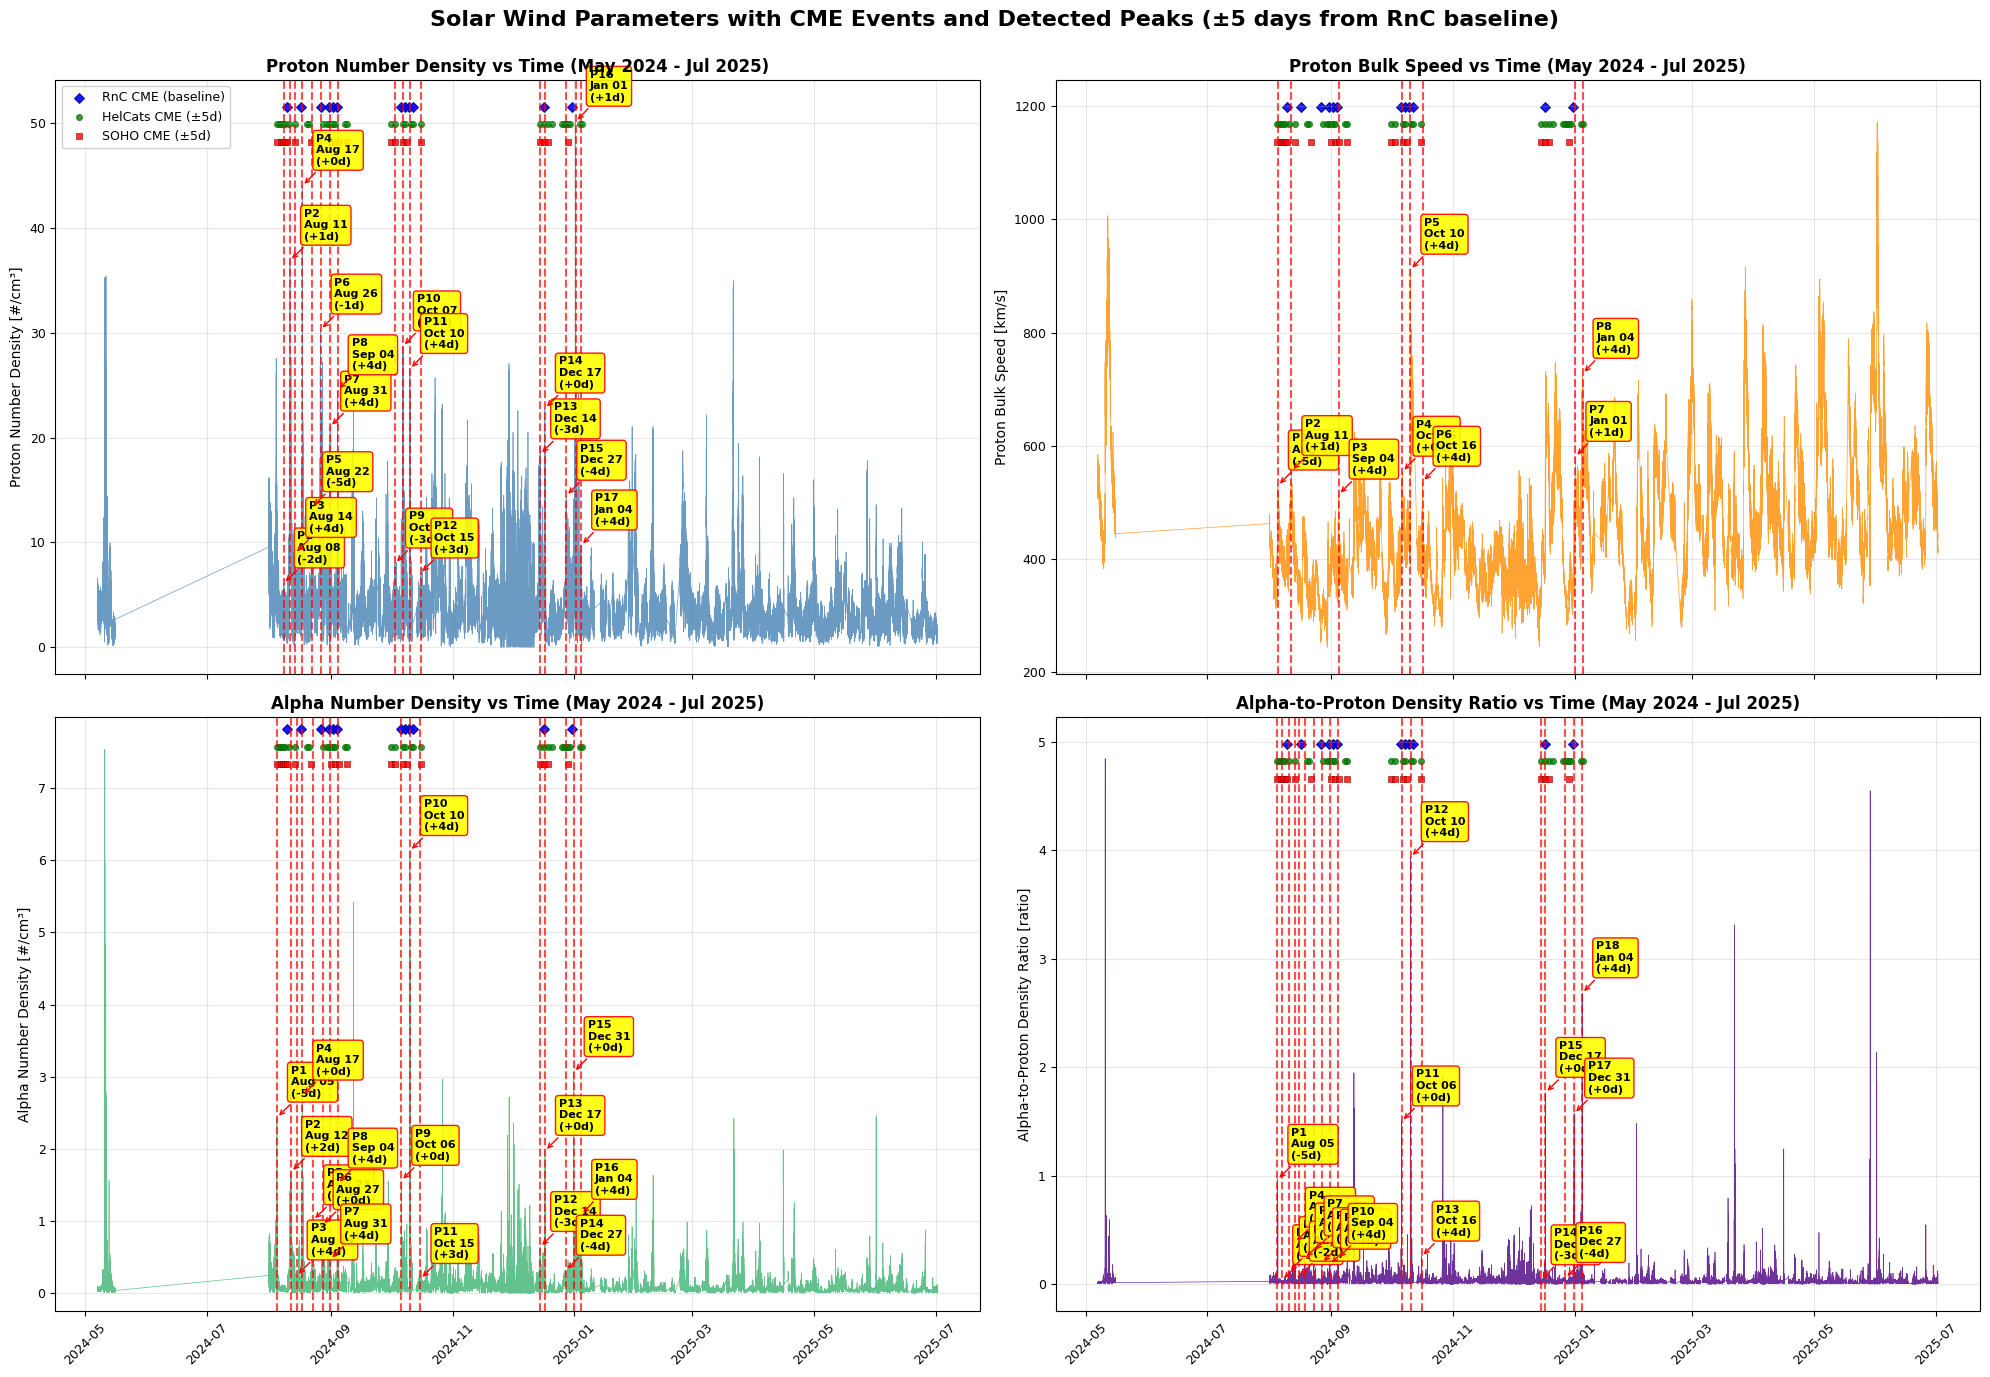


DETAILED PEAK ANALYSIS RESULTS

RnC Baseline Events (12 events):
   1. 2024-08-10
   2. 2024-08-17
   3. 2024-08-27
   4. 2024-08-31
   5. 2024-09-02
   6. 2024-09-04
   7. 2024-10-06
   8. 2024-10-08
   9. 2024-10-10
  10. 2024-10-12
  11. 2024-12-17
  12. 2024-12-31

Matched HelCats Events (35 events):
   1. 2024-08-05
   2. 2024-08-06
   3. 2024-08-07
   4. 2024-08-08
   5. 2024-08-09
   6. 2024-08-11
   7. 2024-08-14
   8. 2024-08-20
   9. 2024-08-21
  10. 2024-08-28
  11. 2024-08-30
  12. 2024-08-31
  13. 2024-09-01
  14. 2024-09-02
  15. 2024-09-03
  16. 2024-09-08
  17. 2024-09-09
  18. 2024-10-01
  19. 2024-10-03
  20. 2024-10-07
  21. 2024-10-08
  22. 2024-10-11
  23. 2024-10-12
  24. 2024-10-16
  25. 2024-12-15
  26. 2024-12-17
  27. 2024-12-19
  28. 2024-12-21
  29. 2024-12-26
  30. 2024-12-27
  31. 2024-12-28
  32. 2024-12-29
  33. 2024-12-30
  34. 2025-01-04
  35. 2025-01-05

Matched SOHO Events (20 events):
   1. 2024-08-05
   2. 2024-08-07
   3. 2024-08-08
   4. 2024-08

In [38]:

# Enhanced CME Analysis with ±5 day filtering and peak detection
if 'merged_df' in locals() and len(merged_df) > 0:
    print("Creating enhanced CME analysis with ±5 day filtering...")

    # Import scipy for peak detection
    from scipy.signal import find_peaks
    from datetime import timedelta

    # Calculate actual date range
    start_date = merged_df['UTC'].min()
    end_date = merged_df['UTC'].max()
    duration_days = (end_date - start_date).days
    duration_months = duration_days / 30.44

    print(f"Data span: {duration_days} days ({duration_months:.1f} months)")

    # Filter RnC dates to baseline period (01/08/2024 - 31/12/2024)
    baseline_start = pd.to_datetime('2024-08-01')
    baseline_end = pd.to_datetime('2024-12-31')

    # Get RnC dates in baseline period
    rnc_dates_baseline = pd.to_datetime(rnc_df['dates'].dropna(), format='%Y/%m/%d', errors='coerce')
    rnc_baseline_filtered = rnc_dates_baseline[
        (rnc_dates_baseline >= baseline_start) &
        (rnc_dates_baseline <= baseline_end)
    ].drop_duplicates().sort_values()

    print(f"\nBaseline RnC dates (Aug-Dec 2024): {len(rnc_baseline_filtered)} events")

    # Find matching HelCats and SOHO dates within ±5 days of RnC dates
    helcats_dates_all = pd.to_datetime(helcats_df['dates'].dropna(), format='%Y/%m/%d', errors='coerce')
    soho_dates_all = pd.to_datetime(soho_df['dates'].dropna(), format='%Y/%m/%d', errors='coerce')

    matched_helcats = []
    matched_soho = []
    matched_rnc = []

    for rnc_date in rnc_baseline_filtered:
        # Define ±5 day window
        window_start = rnc_date - timedelta(days=5)
        window_end = rnc_date + timedelta(days=5)

        # Find HelCats dates in window
        helcats_in_window = helcats_dates_all[
            (helcats_dates_all >= window_start) &
            (helcats_dates_all <= window_end)
        ]

        # Find SOHO dates in window
        soho_in_window = soho_dates_all[
            (soho_dates_all >= window_start) &
            (soho_dates_all <= window_end)
        ]

        # If we have matches in both catalogues, keep this RnC date
        if len(helcats_in_window) > 0 and len(soho_in_window) > 0:
            matched_rnc.append(rnc_date)
            matched_helcats.extend(helcats_in_window.tolist())
            matched_soho.extend(soho_in_window.tolist())

    # Remove duplicates and convert to pandas Series
    matched_helcats = pd.Series(matched_helcats).drop_duplicates().sort_values()
    matched_soho = pd.Series(matched_soho).drop_duplicates().sort_values()
    matched_rnc = pd.Series(matched_rnc).drop_duplicates().sort_values()

    print(f"\nMatched CME events (±5 days from RnC baseline):")
    print(f"  RnC (baseline): {len(matched_rnc)} events")
    print(f"  HelCats (matched): {len(matched_helcats)} events")
    print(f"  SOHO (matched): {len(matched_soho)} events")

    # Filter to data time range
    data_start = merged_df['UTC'].min()
    data_end = merged_df['UTC'].max()

    helcats_in_range = matched_helcats[(matched_helcats >= data_start) & (matched_helcats <= data_end)]
    soho_in_range = matched_soho[(matched_soho >= data_start) & (matched_soho <= data_end)]
    rnc_in_range = matched_rnc[(matched_rnc >= data_start) & (matched_rnc <= data_end)]

    print(f"\nCME events within data range:")
    print(f"  RnC: {len(rnc_in_range)} events")
    print(f"  HelCats: {len(helcats_in_range)} events")
    print(f"  SOHO: {len(soho_in_range)} events")

    # Create figure with adjusted dimensions
    fig, axs = plt.subplots(2, 2, figsize=(20, 14), sharex=True)

    # Enhanced plot configurations using metadata
    plot_configs = [
        {
            'var': 'Proton_Density',
            'ax': axs[0, 0],
            'color': 'steelblue',
            'config': VARIABLE_CONFIG['proton_density']
        },
        {
            'var': 'Proton_Bulk_Speed',
            'ax': axs[0, 1],
            'color': 'darkorange',
            'config': VARIABLE_CONFIG['proton_bulk_speed']
        },
        {
            'var': 'Alpha_Density',
            'ax': axs[1, 0],
            'color': 'mediumseagreen',
            'config': VARIABLE_CONFIG['alpha_density']
        },
        {
            'var': 'He2p_Hp_Ratio',
            'ax': axs[1, 1],
            'color': 'indigo',
            'config': {'label': 'Alpha-to-Proton Density Ratio', 'units': 'ratio', 'fillval': -1e31, 'sig_digits': 3}
        }
    ]

    # Function to find peaks within CME windows
    def find_peaks_in_cme_windows(data, time_data, rnc_dates, window_days=5):
        """Find peaks that occur within ±window_days of RnC events"""
        peaks_in_windows = []
        peak_cme_associations = []
        peak_dates = []
        peak_values = []

        # First find all peaks in the data
        valid_indices = ~np.isnan(data)
        valid_data = data[valid_indices]
        valid_idx = np.where(valid_indices)[0]

        if len(valid_data) < 10:
            return [], [], [], []

        # Find peaks with reasonable parameters
        min_distance = max(len(valid_data) // 100, 20)
        height_threshold = np.percentile(valid_data, 75)  # Above 75th percentile
        prominence = np.std(valid_data) * 0.3

        peaks, properties = find_peaks(valid_data,
                                     distance=min_distance,
                                     prominence=prominence,
                                     height=height_threshold)

        if len(peaks) == 0:
            return [], [], [], []

        # Check which peaks fall within ±5 days of RnC dates
        for peak_idx in valid_idx[peaks]:
            peak_time = time_data.iloc[peak_idx]
            peak_value = data[peak_idx]

            # Check if peak is within any RnC window
            for rnc_date in rnc_dates:
                window_start = rnc_date - timedelta(days=window_days)
                window_end = rnc_date + timedelta(days=window_days)

                if window_start <= peak_time <= window_end:
                    peaks_in_windows.append(peak_idx)
                    peak_cme_associations.append(rnc_date)
                    peak_dates.append(peak_time)
                    peak_values.append(peak_value)
                    break

        return peaks_in_windows, peak_cme_associations, peak_dates, peak_values

    # Store all peak information for output
    all_peak_info = {}
    peak_summary = []

    # Plot each variable with enhanced metadata and CME-associated peaks
    for plot_config in plot_configs:
        var_name = plot_config['var']
        ax = plot_config['ax']
        color = plot_config['color']
        config = plot_config['config']

        if var_name in merged_df.columns:
            y_data = merged_df[var_name]
            x_data = merged_df['UTC']

            # Filter out fill values
            fillval = config.get('fillval', -1e31)
            valid_mask = (y_data != fillval) & np.isfinite(y_data)
            x_data_clean = x_data[valid_mask]
            y_data_clean = y_data[valid_mask]

            # Plot main data
            ax.plot(x_data_clean, y_data_clean, color=color, linewidth=0.5, alpha=0.8)

            # Custom fix for Alpha Density scaling
            if var_name == 'Alpha_Density':
                ax.set_ylim(-0.25, 7.99)

            # Set labels using metadata
            ylabel = f"{config['label']} [{config['units']}]"
            title = f"{config['label']} vs Time ({start_date.strftime('%b %Y')} - {end_date.strftime('%b %Y')})"

            ax.set_ylabel(ylabel, fontsize=10)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)

            # Find peaks within ±5 days of RnC dates
            peak_indices, peak_rnc_dates, peak_dates, peak_vals = find_peaks_in_cme_windows(
                y_data.values, merged_df['UTC'], rnc_in_range, window_days=5
            )

            # Store peak information
            all_peak_info[var_name] = []

            # Annotate peaks
            for i, (peak_idx, associated_rnc, peak_date, peak_value) in enumerate(
                zip(peak_indices, peak_rnc_dates, peak_dates, peak_vals)):

                # Add vertical dotted line
                ax.axvline(x=peak_date, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

                # Add annotation with peak info
                days_diff = (peak_date - associated_rnc).days
                ax.annotate(f'P{i+1}\n{peak_date.strftime("%b %d")}\n({days_diff:+d}d)',
                           xy=(peak_date, peak_value),
                           xytext=(10, 15), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.9, edgecolor='red'),
                           fontsize=8, ha='left', weight='bold',
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))

                # Store peak information
                peak_info = {
                    'variable': var_name,
                    'peak_number': i+1,
                    'peak_date': peak_date.strftime('%Y-%m-%d %H:%M:%S'),
                    'peak_value': round(peak_value, config.get('sig_digits', 3)),
                    'associated_rnc_date': associated_rnc.strftime('%Y-%m-%d'),
                    'days_from_rnc': days_diff,
                    'units': config['units']
                }
                all_peak_info[var_name].append(peak_info)
                peak_summary.append(peak_info)

            print(f"{var_name}: Found {len(peak_indices)} peaks within ±5 days of RnC events")

        else:
            ax.text(0.5, 0.5, f'{var_name}\nNot Available',
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"{config['label']} (No Data)", fontsize=12)

    # Add CME markers to all subplots
    for ax in axs.flat:
        y_min, y_max = ax.get_ylim()

        # Calculate different heights for each catalogue (top 10% of plot area)
        rnc_height = y_max - 0.02 * (y_max - y_min)      # Top (baseline)
        helcats_height = y_max - 0.05 * (y_max - y_min)  # Middle
        soho_height = y_max - 0.08 * (y_max - y_min)     # Bottom

        # Plot CME markers
        if len(rnc_in_range) > 0:
            ax.scatter(rnc_in_range, [rnc_height] * len(rnc_in_range),
                      color='blue', s=25, alpha=0.9, marker='D',
                      label='RnC CME (baseline)' if ax == axs[0,0] else "",
                      edgecolors='darkblue', linewidth=0.8)

        if len(helcats_in_range) > 0:
            ax.scatter(helcats_in_range, [helcats_height] * len(helcats_in_range),
                      color='green', s=20, alpha=0.8, marker='o',
                      label='HelCats CME (±5d)' if ax == axs[0,0] else "",
                      edgecolors='darkgreen', linewidth=0.5)

        if len(soho_in_range) > 0:
            ax.scatter(soho_in_range, [soho_height] * len(soho_in_range),
                      color='red', s=20, alpha=0.8, marker='s',
                      label='SOHO CME (±5d)' if ax == axs[0,0] else "",
                      edgecolors='darkred', linewidth=0.5)

    # Add legend to the first subplot
    axs[0,0].legend(loc='upper left', fontsize=9, framealpha=0.9)

    # Format x-axis for all subplots
    for ax in axs.flat:
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)

    # Adjust layout and add main title
    plt.suptitle('Solar Wind Parameters with CME Events and Detected Peaks (±5 days from RnC baseline)',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

    # Output detailed peak information
    print("\n" + "="*80)
    print("DETAILED PEAK ANALYSIS RESULTS")
    print("="*80)

    print(f"\nRnC Baseline Events ({len(rnc_in_range)} events):")
    for i, date in enumerate(rnc_in_range, 1):
        print(f"  {i:2d}. {date.strftime('%Y-%m-%d')}")

    print(f"\nMatched HelCats Events ({len(helcats_in_range)} events):")
    for i, date in enumerate(helcats_in_range, 1):
        print(f"  {i:2d}. {date.strftime('%Y-%m-%d')}")

    print(f"\nMatched SOHO Events ({len(soho_in_range)} events):")
    for i, date in enumerate(soho_in_range, 1):
        print(f"  {i:2d}. {date.strftime('%Y-%m-%d')}")

    if peak_summary:
        print(f"\nDETECTED PEAKS WITHIN ±5 DAYS OF RnC EVENTS ({len(peak_summary)} total peaks):")
        print("-" * 120)
        print(f"{'Var':<20} {'Peak#':<6} {'Peak Date/Time':<20} {'Value':<12} {'Units':<15} {'RnC Date':<12} {'Days':<5}")
        print("-" * 120)

        for peak in peak_summary:
            print(f"{peak['variable']:<20} {peak['peak_number']:<6} {peak['peak_date']:<20} "
                  f"{peak['peak_value']:<12} {peak['units']:<15} {peak['associated_rnc_date']:<12} {peak['days_from_rnc']:+d}")

    else:
        print("\nNo significant peaks detected within ±5 days of RnC events.")

    # Summary statistics
    print(f"\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"RnC Baseline Period: 2024-08-01 to 2024-12-31")
    print(f"Total RnC baseline events: {len(rnc_baseline_filtered)}")
    print(f"RnC events with matches in both catalogues: {len(matched_rnc)}")
    print(f"RnC events within data range: {len(rnc_in_range)}")
    print(f"Total peaks detected: {len(peak_summary)}")

    # Count peaks by variable
    peak_counts = {}
    for peak in peak_summary:
        var = peak['variable']
        peak_counts[var] = peak_counts.get(var, 0) + 1

    print("\nPeaks by variable:")
    for var, count in peak_counts.items():
        print(f"  {var}: {count} peaks")

else:
    print("Error: merged_df not found. Please run the data loading and merging cells")
